In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from os.path import join
import torch
import torch as th
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import os
from os.path import join
import torch
import torch as th
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha")
from diffusion import IDDPM
from diffusion.data.builder import build_dataset, build_dataloader, set_data_root
from diffusion.model.builder import build_model
from diffusion.utils.misc import set_random_seed, read_config, init_random_seed, DebugUnderflowOverflow
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation")
from utils.pixart_sampling_utils import pipeline_inference_custom, \
    PixArtAlphaPipeline_custom, PixArtAlphaPipeline_custom_CLIP
from utils.pixart_utils import state_dict_convert
from utils.text_encoder_control_lib import RandomEmbeddingEncoder_wPosEmb
from utils.image_utils import pil_images_to_grid
from utils.attention_map_store_utils import replace_attn_processor, AttnProcessor2_0_Store, PixArtAttentionVisualizer_Store
from utils.cv2_eval_utils import find_classify_object_masks
from diffusers import AutoencoderKL, Transformer2DModel, PixArtAlphaPipeline, DPMSolverMultistepScheduler
from transformers import T5Tokenizer, T5EncoderModel

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Pleas

In [4]:
from transformers import CLIPTextModelWithProjection, CLIPTokenizer
# Load SDXL's text encoder and tokenizer (text_encoder_2 and tokenizer_2)
text_encoder = CLIPTextModelWithProjection.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", subfolder="text_encoder_2", 
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",)
tokenizer = CLIPTokenizer.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", subfolder="tokenizer_2", 
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",)

In [5]:
savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_CLIPemb_DiT_mini_pilot"

config = read_config(join(savedir, 'config.py'))

weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
image_size = config.image_size  # @param [256, 512, 1024]
latent_size = int(image_size) // 8
pred_sigma = getattr(config, 'pred_sigma', True)
learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                'model_max_length': config.model_max_length, "caption_channels": config.caption_channels}
# train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
model = build_model(config.model,
                config.grad_checkpointing,
                config.get('fp32_attention', False),
                input_size=latent_size,
                learn_sigma=learn_sigma,
                pred_sigma=pred_sigma,
                **model_kwargs).train()

transformer = Transformer2DModel(
        sample_size=image_size // 8,
        num_layers=len(model.blocks),
        attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
        in_channels=model.in_channels,
        out_channels=model.out_channels,
        patch_size=model.patch_size,
        attention_bias=True,
        num_attention_heads=model.num_heads,
        cross_attention_dim=model.blocks[0].hidden_size,
        activation_fn="gelu-approximate",
        num_embeds_ada_norm=1000,
        norm_type="ada_norm_single",
        norm_elementwise_affine=False,
        norm_eps=1e-6,
        caption_channels=config.caption_channels,
)
# state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
transformer.load_state_dict(state_dict_convert(model.state_dict()))
pipeline = PixArtAlphaPipeline_custom_CLIP.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=None,
    text_encoder=None,
    torch_dtype=weight_dtype,
)

pipeline.tokenizer = tokenizer
pipeline.to(device="cuda", dtype=weight_dtype);
# pipeline.to(device="cuda", dtype=torch.bfloat16);
pipeline.text_encoder = text_encoder.to(device="cuda", )

2026-01-25 02:08:45,617 - PixArt - WARNING - lewei scale: (1.0,), base size: 8


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.


In [6]:
ckptdir = join(savedir, "checkpoints")
ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict_ema']))

/tmp/ipykernel_2225839/1495998778.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))


<All keys matched successfully>

### Ablation

In [7]:
from experimental_scripts.generalization_profile_eval_cli import evaluate_pipeline_on_prompts_with_cached_embeddings, precompute_embeddings
from copy import deepcopy

def print_evaluation_summary_concise(eval_df, group_by_prompt=True, show=True):
    print_df = eval_df.select_dtypes(include=['number', 'bool']).drop(columns=['prompt_id', 'sample_id'], errors='ignore').mean().round(3).to_frame().T
    if show:
        display(print_df)
    return print_df

In [13]:
attn_ablation_figdir = "/n/home12/binxuwang/Github/DiffusionObjectRelation/Figures/DiT_mini_CLIP_attn_ablation_figures"
os.makedirs(attn_ablation_figdir, exist_ok=True)

In [15]:
pipeline.set_progress_bar_config(disable=True)

In [17]:
prompt = "blue circle is to the upper left of red square"
scene_info = {'color1': 'blue',
  'shape1': 'circle',
  'color2': 'red',
  'shape2': 'square',
  'spatial_relationship': 'upper_left'}

prompt = "blue circle is to the left of red square"
scene_info = {'color1': 'blue',
  'shape1': 'circle',
  'color2': 'red',
  'shape2': 'square',
  'spatial_relationship': 'left'}
embedding_cache = precompute_embeddings({"base":([prompt], [scene_info])}, 
                                        pipeline.tokenizer, pipeline.text_encoder, 
                                        max_sequence_length=20, device="cuda")

In [18]:
print(prompt)
token_ids = pipeline.tokenizer.encode(prompt, add_special_tokens=True)
token_list = pipeline.tokenizer.convert_ids_to_tokens(token_ids)
eval_df_list = []
summary_eval_df_list = []
print("without attention masking ", embedding_cache[f'base::{prompt}']['emb_mask'])
eval_df, object_df = evaluate_pipeline_on_prompts_with_cached_embeddings(pipeline, [prompt], [scene_info], embedding_cache,
                                                       num_images=49, num_inference_steps=14, guidance_scale=4.5,
                                                       generator_seed=42, color_margin=25, spatial_threshold=5, 
                                                       device="cuda", weight_dtype=torch.float16)
summary_eval_df = print_evaluation_summary_concise(eval_df, group_by_prompt=False, show=False)
summary_eval_df["mask_idx"] = -1
summary_eval_df["masked_token"] = ""
summary_eval_df_list.append(summary_eval_df)
eval_df["mask_idx"] = -1
eval_df["masked_token"] = ""
eval_df_list.append(eval_df)

embmask_tmp = embedding_cache[f'base::{prompt}']['emb_mask'].clone()
for i in range(len(embmask_tmp[0])):
    embmask_tmp = embedding_cache[f'base::{prompt}']['emb_mask'].clone()
    embedding_cache_copy = deepcopy(embedding_cache)
    if embmask_tmp[0,i] == 0:
        continue
    embmask_tmp[0,i] = 0
    embedding_cache_copy[f'base::{prompt}']['emb_mask'] = embmask_tmp
    print("with attention masking ", embedding_cache_copy[f'base::{prompt}']['emb_mask'])
    eval_df, object_df = evaluate_pipeline_on_prompts_with_cached_embeddings(pipeline, [prompt], [scene_info], embedding_cache_copy,
                                                        num_images=49, num_inference_steps=14, guidance_scale=4.5,
                                                        generator_seed=42, color_margin=25, spatial_threshold=5, 
                                                        device="cuda", weight_dtype=torch.float16)
    summary_eval_df = print_evaluation_summary_concise(eval_df, group_by_prompt=False, show=False)
    summary_eval_df["mask_idx"] = i
    summary_eval_df["masked_token"] = token_list[i]
    summary_eval_df_list.append(summary_eval_df)
    eval_df["mask_idx"] = -1
    eval_df["masked_token"] = ""
    eval_df_list.append(eval_df)

summary_eval_df = pd.concat(summary_eval_df_list)
display(summary_eval_df.set_index(["mask_idx", "masked_token"], ))
summary_eval_df.to_csv(join(attn_ablation_figdir, f"summary_eval_df_prompt_{prompt.replace(' ', '_')}.csv"))

eval_df_all = pd.concat(eval_df_list)
eval_df_all.to_csv(join(attn_ablation_figdir, f"eval_df_all_prompt_{prompt.replace(' ', '_')}.csv"))

blue circle is to the left of red square
without attention masking  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

overall  overall_loose  shape  color  exist_binding  \
mask_idx masked_token                                                           
-1                          0.265          0.816  0.939  0.837          0.816   
 0       <|startoftext|>    0.265          0.776  0.918  0.837          0.816   
 1       blue</w>           0.245          0.816  0.939  0.837          0.816   
 2       circle</w>         0.265          0.571  0.673  0.714          0.571   
 3       is</w>             0.265          0.816  0.939  0.837          0.816   
 4       to</w>             0.265          0.816  0.918  0.837          0.816   
 5       the</w>            0.286          0.816  0.939  0.837          0.816   
 6       left</w>           0.245          0.816  0.918  0.837          0.816   
 7       of</w>             0.245          0.816  0.939  0.837          0.816   
 8       red</w>            0.265          0.816  0.898  0.837          0.816   
 9       square</w>         0.102          0.306  0.490  0.408          0.306   
 10      <|endoftext|>      0.204          0.980  0.980  1.000          0.980   

                          unique_binding  spatial_relationship  \
mask_idx masked_token                                            
-1                                 0.816                 0.265   
 0       <|startoftext|>           0.776                 0.265   
 1       blue</w>                  0.816                 0.245   
 2       circle</w>                0.571                 0.265   
 3       is</w>                    0.816                 0.265   
 4       to</w>                    0.816                 0.265   
 5       the</w>                   0.816                 0.286   
 6       left</w>                  0.816                 0.245   
 7       of</w>                    0.816                 0.245   
 8       red</w>                   0.816                 0.265   
 9       square</w>                0.306                 0.102   
 10      <|endoftext|>             0.980                 0.204   

                          spatial_relationship_loose      Dx     Dy      x1  \
mask_idx masked_token                                                         
-1                                             0.816 -67.650  5.325  34.475   
 0       <|startoftext|>                       0.776 -67.500  4.632  34.921   
 1       blue</w>                              0.816 -67.875  4.850  34.700   
 2       circle</w>                            0.571 -63.893  1.321  37.964   
 3       is</w>                                0.816 -67.925  5.075  34.675   
 4       to</w>                                0.816 -67.850  4.775  34.725   
 5       the</w>                               0.816 -67.875  4.350  34.700   
 6       left</w>                              0.816 -67.900  4.850  34.700   
 7       of</w>                                0.816 -67.775  6.375  34.800   
 8       red</w>                               0.816 -69.325  5.725  32.225   
 9       square</w>                            0.306 -34.533 -0.600  67.333   
 10      <|endoftext|>                         0.980 -65.396 -7.562  32.792   

                              y1       x2      y2  
mask_idx masked_token                              
-1                        60.750  102.125  55.425  
 0       <|startoftext|>  58.895  102.421  54.263  
 1       blue</w>         57.825  102.575  52.975  
 2       circle</w>       61.571  101.857  60.250  
 3       is</w>           57.800  102.600  52.725  
 4       to</w>           57.800  102.575  53.025  
 5       the</w>          57.825  102.575  53.475  
 6       left</w>         57.825  102.600  52.975  
 7       of</w>           59.400  102.575  53.025  
 8       red</w>          60.525  101.550  54.800  
 9       square</w>       54.933  101.867  55.533  
 10      <|endoftext|>    65.667   98.188  73.229

In [ ]:
prompt = "blue circle is to the upper left of red square"
scene_info = {'color1': 'blue',
  'shape1': 'circle',
  'color2': 'red',
  'shape2': 'square',
  'spatial_relationship': 'upper_left'}

embedding_cache = precompute_embeddings({"base":([prompt], [scene_info])}, 
                                        pipeline.tokenizer, pipeline.text_encoder, 
                                        max_sequence_length=20, device="cuda")

In [16]:
print(prompt)
token_ids = pipeline.tokenizer.encode(prompt, add_special_tokens=True)
token_list = pipeline.tokenizer.convert_ids_to_tokens(token_ids)
eval_df_list = []
summary_eval_df_list = []
print("without attention masking ", embedding_cache[f'base::{prompt}']['emb_mask'])
eval_df, object_df = evaluate_pipeline_on_prompts_with_cached_embeddings(pipeline, [prompt], [scene_info], embedding_cache,
                                                       num_images=49, num_inference_steps=14, guidance_scale=4.5,
                                                       generator_seed=42, color_margin=25, spatial_threshold=5, 
                                                       device="cuda", weight_dtype=torch.float16)
summary_eval_df = print_evaluation_summary_concise(eval_df, group_by_prompt=False, show=False)
summary_eval_df["mask_idx"] = -1
summary_eval_df["masked_token"] = ""
summary_eval_df_list.append(summary_eval_df)
eval_df["mask_idx"] = -1
eval_df["masked_token"] = ""
eval_df_list.append(eval_df)

embmask_tmp = embedding_cache[f'base::{prompt}']['emb_mask'].clone()
for i in range(len(embmask_tmp[0])):
    embmask_tmp = embedding_cache[f'base::{prompt}']['emb_mask'].clone()
    embedding_cache_copy = deepcopy(embedding_cache)
    if embmask_tmp[0,i] == 0:
        continue
    embmask_tmp[0,i] = 0
    embedding_cache_copy[f'base::{prompt}']['emb_mask'] = embmask_tmp
    print("with attention masking ", embedding_cache_copy[f'base::{prompt}']['emb_mask'])
    eval_df, object_df = evaluate_pipeline_on_prompts_with_cached_embeddings(pipeline, [prompt], [scene_info], embedding_cache_copy,
                                                        num_images=49, num_inference_steps=14, guidance_scale=4.5,
                                                        generator_seed=42, color_margin=25, spatial_threshold=5, 
                                                        device="cuda", weight_dtype=torch.float16)
    summary_eval_df = print_evaluation_summary_concise(eval_df, group_by_prompt=False, show=False)
    summary_eval_df["mask_idx"] = i
    summary_eval_df["masked_token"] = token_list[i]
    summary_eval_df_list.append(summary_eval_df)
    eval_df["mask_idx"] = -1
    eval_df["masked_token"] = ""
    eval_df_list.append(eval_df)

summary_eval_df = pd.concat(summary_eval_df_list)
display(summary_eval_df.set_index(["mask_idx", "masked_token"], ))
summary_eval_df.to_csv(join(attn_ablation_figdir, f"summary_eval_df_prompt_{prompt.replace(' ', '_')}.csv"))

eval_df_all = pd.concat(eval_df_list)
eval_df_all.to_csv(join(attn_ablation_figdir, f"eval_df_all_prompt_{prompt.replace(' ', '_')}.csv"))

blue circle is to the upper left of red square
without attention masking  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

overall  overall_loose  shape  color  exist_binding  \
mask_idx masked_token                                                           
-1                          0.959          0.959  1.000  1.000          1.000   
 0       <|startoftext|>    0.959          0.959  1.000  1.000          1.000   
 1       blue</w>           0.959          0.959  1.000  1.000          1.000   
 2       circle</w>         0.939          0.939  0.959  1.000          0.959   
 3       is</w>             0.959          0.959  1.000  1.000          1.000   
 4       to</w>             0.959          0.959  1.000  1.000          1.000   
 5       the</w>            0.959          0.959  1.000  1.000          1.000   
 6       upper</w>          0.959          0.959  1.000  1.000          1.000   
 7       left</w>           0.959          0.959  1.000  1.000          1.000   
 8       of</w>             0.959          0.959  1.000  1.000          1.000   
 9       red</w>            0.959          0.959  1.000  1.000          1.000   
 10      square</w>         0.122          0.122  0.673  0.776          0.551   
 11      <|endoftext|>      0.980          0.980  0.980  1.000          0.980   

                          unique_binding  spatial_relationship  \
mask_idx masked_token                                            
-1                                 1.000                 0.959   
 0       <|startoftext|>           1.000                 0.959   
 1       blue</w>                  1.000                 0.959   
 2       circle</w>                0.959                 0.939   
 3       is</w>                    1.000                 0.959   
 4       to</w>                    1.000                 0.959   
 5       the</w>                   1.000                 0.959   
 6       upper</w>                 1.000                 0.959   
 7       left</w>                  1.000                 0.959   
 8       of</w>                    1.000                 0.959   
 9       red</w>                   1.000                 0.959   
 10      square</w>                0.551                 0.122   
 11      <|endoftext|>             0.980                 0.980   

                          spatial_relationship_loose      Dx      Dy      x1  \
mask_idx masked_token                                                          
-1                                             0.959 -53.224 -46.837  41.102   
 0       <|startoftext|>                       0.959 -53.592 -46.633  40.939   
 1       blue</w>                              0.959 -53.714 -46.592  40.735   
 2       circle</w>                            0.939 -51.638 -49.319  42.404   
 3       is</w>                                0.959 -53.531 -46.714  40.959   
 4       to</w>                                0.959 -53.510 -46.694  40.939   
 5       the</w>                               0.959 -53.429 -46.673  40.959   
 6       upper</w>                             0.959 -53.755 -46.612  40.735   
 7       left</w>                              0.959 -53.531 -46.714  40.939   
 8       of</w>                                0.959 -53.735 -46.612  40.735   
 9       red</w>                               0.959 -52.980 -44.245  41.102   
 10      square</w>                            0.122 -15.741   4.704  68.778   
 11      <|endoftext|>                         0.980 -54.812 -55.375  41.292   

                              y1      x2      y2  
mask_idx masked_token                             
-1                        39.694  94.327  86.531  
 0       <|startoftext|>  39.878  94.531  86.510  
 1       blue</w>         39.857  94.449  86.449  
 2       circle</w>       38.979  94.043  88.298  
 3       is</w>           39.816  94.490  86.531  
 4       to</w>           39.796  94.449  86.490  
 5       the</w>          39.796  94.388  86.469  
 6       upper</w>        39.898  94.490  86.510  
 7       left</w>         39.816  94.469  86.531  
 8       of</w>           39.857  94.469  86.469  
 9    

In [20]:
prompt = "blue triangle is above red square"
scene_info = {'color1': 'blue',
  'shape1': 'triangle',
  'color2': 'red',
  'shape2': 'square',
  'spatial_relationship': 'above'}

embedding_cache = precompute_embeddings({"base":([prompt], [scene_info])}, 
                                        pipeline.tokenizer, pipeline.text_encoder, 
                                        max_sequence_length=20, device="cuda")
print(prompt)
token_ids = pipeline.tokenizer.encode(prompt, add_special_tokens=True)
token_list = pipeline.tokenizer.convert_ids_to_tokens(token_ids)
eval_df_list = []
summary_eval_df_list = []
print("without attention masking ", embedding_cache[f'base::{prompt}']['emb_mask'])
eval_df, object_df = evaluate_pipeline_on_prompts_with_cached_embeddings(pipeline, [prompt], [scene_info], embedding_cache,
                                                       num_images=49, num_inference_steps=14, guidance_scale=4.5,
                                                       generator_seed=42, color_margin=25, spatial_threshold=5, 
                                                       device="cuda", weight_dtype=torch.float16)
summary_eval_df = print_evaluation_summary_concise(eval_df, group_by_prompt=False, show=False)
summary_eval_df["mask_idx"] = -1
summary_eval_df["masked_token"] = ""
summary_eval_df_list.append(summary_eval_df)
eval_df["mask_idx"] = -1
eval_df["masked_token"] = ""
eval_df_list.append(eval_df)

embmask_tmp = embedding_cache[f'base::{prompt}']['emb_mask'].clone()
for i in range(len(embmask_tmp[0])):
    embmask_tmp = embedding_cache[f'base::{prompt}']['emb_mask'].clone()
    embedding_cache_copy = deepcopy(embedding_cache)
    if embmask_tmp[0,i] == 0:
        continue
    embmask_tmp[0,i] = 0
    embedding_cache_copy[f'base::{prompt}']['emb_mask'] = embmask_tmp
    print("with attention masking ", embedding_cache_copy[f'base::{prompt}']['emb_mask'])
    eval_df, object_df = evaluate_pipeline_on_prompts_with_cached_embeddings(pipeline, [prompt], [scene_info], embedding_cache_copy,
                                                        num_images=49, num_inference_steps=14, guidance_scale=4.5,
                                                        generator_seed=42, color_margin=25, spatial_threshold=5, 
                                                        device="cuda", weight_dtype=torch.float16)
    summary_eval_df = print_evaluation_summary_concise(eval_df, group_by_prompt=False, show=False)
    summary_eval_df["mask_idx"] = i
    summary_eval_df["masked_token"] = token_list[i]
    summary_eval_df_list.append(summary_eval_df)
    eval_df["mask_idx"] = -1
    eval_df["masked_token"] = ""
    eval_df_list.append(eval_df)

summary_eval_df = pd.concat(summary_eval_df_list)
display(summary_eval_df.set_index(["mask_idx", "masked_token"], ))
summary_eval_df.to_csv(join(attn_ablation_figdir, f"summary_eval_df_prompt_{prompt.replace(' ', '_')}.csv"))

eval_df_all = pd.concat(eval_df_list)
eval_df_all.to_csv(join(attn_ablation_figdir, f"eval_df_all_prompt_{prompt.replace(' ', '_')}.csv"))

Pre-computing text embeddings for all prompts...
Computing unconditional embedding...


Computing embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

Cached embeddings for 2 unique prompts (including uncond)
blue triangle is above red square
without attention masking  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

overall  overall_loose  shape  color  exist_binding  \
mask_idx masked_token                                                           
-1                          0.714          0.837  0.857  0.898          0.837   
 0       <|startoftext|>    0.633          0.755  0.878  0.816          0.755   
 1       blue</w>           0.694          0.755  0.857  0.857          0.755   
 2       triangle</w>       0.041          0.041  0.367  0.122          0.041   
 3       is</w>             0.673          0.755  0.857  0.857          0.755   
 4       above</w>          0.653          0.735  0.857  0.816          0.735   
 5       red</w>            0.714          0.837  0.918  0.878          0.837   
 6       square</w>         0.122          0.143  0.265  0.388          0.184   
 7       <|endoftext|>      0.327          0.959  1.000  0.959          0.959   

                          unique_binding  spatial_relationship  \
mask_idx masked_token                                            
-1                                 0.837                 0.714   
 0       <|startoftext|>           0.755                 0.633   
 1       blue</w>                  0.755                 0.694   
 2       triangle</w>              0.041                 0.041   
 3       is</w>                    0.755                 0.673   
 4       above</w>                 0.735                 0.653   
 5       red</w>                   0.837                 0.714   
 6       square</w>                0.184                 0.122   
 7       <|endoftext|>             0.959                 0.327   

                          spatial_relationship_loose      Dx      Dy      x1  \
mask_idx masked_token                                                          
-1                                             0.837   3.341 -34.780  80.732   
 0       <|startoftext|>                       0.755   3.919 -35.324  84.027   
 1       blue</w>                              0.755   2.568 -33.757  84.892   
 2       triangle</w>                          0.041   2.000 -23.000  96.500   
 3       is</w>                                0.755   3.622 -33.784  86.027   
 4       above</w>                             0.735   3.583 -34.444  84.972   
 5       red</w>                               0.837   3.537 -34.634  81.683   
 6       square</w>                            0.143 -17.667 -18.667  43.444   
 7       <|endoftext|>                         0.959  13.000 -54.362  72.319   

                              y1      x2       y2  
mask_idx masked_token                              
-1                        61.341  77.390   96.122  
 0       <|startoftext|>  63.216  80.108   98.541  
 1       blue</w>         66.649  82.324  100.405  
 2       triangle</w>     79.500  94.500  102.500  
 3       is</w>           68.000  82.405  101.784  
 4       above</w>        64.778  81.389   99.222  
 5       red</w>          61.756  78.146   96.390  
 6       square</w>       40.333  61.111   59.000  
 7       <|endoftext|>    37.021  59.319   91.383

In [21]:
prompt = "blue triangle is above and to the right of red square"
scene_info = {'color1': 'blue',
  'shape1': 'triangle',
  'color2': 'red',
  'shape2': 'square',
  'spatial_relationship': 'upper_right'}

embedding_cache = precompute_embeddings({"base":([prompt], [scene_info])}, 
                                        pipeline.tokenizer, pipeline.text_encoder, 
                                        max_sequence_length=20, device="cuda")
print(prompt)
token_ids = pipeline.tokenizer.encode(prompt, add_special_tokens=True)
token_list = pipeline.tokenizer.convert_ids_to_tokens(token_ids)
eval_df_list = []
summary_eval_df_list = []
print("without attention masking ", embedding_cache[f'base::{prompt}']['emb_mask'])
eval_df, object_df = evaluate_pipeline_on_prompts_with_cached_embeddings(pipeline, [prompt], [scene_info], embedding_cache,
                                                       num_images=49, num_inference_steps=14, guidance_scale=4.5,
                                                       generator_seed=42, color_margin=25, spatial_threshold=5, 
                                                       device="cuda", weight_dtype=torch.float16)
summary_eval_df = print_evaluation_summary_concise(eval_df, group_by_prompt=False, show=False)
summary_eval_df["mask_idx"] = -1
summary_eval_df["masked_token"] = ""
summary_eval_df_list.append(summary_eval_df)
eval_df["mask_idx"] = -1
eval_df["masked_token"] = ""
eval_df_list.append(eval_df)

embmask_tmp = embedding_cache[f'base::{prompt}']['emb_mask'].clone()
for i in range(len(embmask_tmp[0])):
    embmask_tmp = embedding_cache[f'base::{prompt}']['emb_mask'].clone()
    embedding_cache_copy = deepcopy(embedding_cache)
    if embmask_tmp[0,i] == 0:
        continue
    embmask_tmp[0,i] = 0
    embedding_cache_copy[f'base::{prompt}']['emb_mask'] = embmask_tmp
    print("with attention masking ", embedding_cache_copy[f'base::{prompt}']['emb_mask'])
    eval_df, object_df = evaluate_pipeline_on_prompts_with_cached_embeddings(pipeline, [prompt], [scene_info], embedding_cache_copy,
                                                        num_images=49, num_inference_steps=14, guidance_scale=4.5,
                                                        generator_seed=42, color_margin=25, spatial_threshold=5, 
                                                        device="cuda", weight_dtype=torch.float16)
    summary_eval_df = print_evaluation_summary_concise(eval_df, group_by_prompt=False, show=False)
    summary_eval_df["mask_idx"] = i
    summary_eval_df["masked_token"] = token_list[i]
    summary_eval_df_list.append(summary_eval_df)
    eval_df["mask_idx"] = -1
    eval_df["masked_token"] = ""
    eval_df_list.append(eval_df)

summary_eval_df = pd.concat(summary_eval_df_list)
display(summary_eval_df.set_index(["mask_idx", "masked_token"], ))
summary_eval_df.to_csv(join(attn_ablation_figdir, f"summary_eval_df_prompt_{prompt.replace(' ', '_')}.csv"))

eval_df_all = pd.concat(eval_df_list)
eval_df_all.to_csv(join(attn_ablation_figdir, f"eval_df_all_prompt_{prompt.replace(' ', '_')}.csv"))

Pre-computing text embeddings for all prompts...
Computing unconditional embedding...


Computing embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

Cached embeddings for 2 unique prompts (including uncond)
blue triangle is above and to the right of red square
without attention masking  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

overall  overall_loose  shape  color  exist_binding  \
mask_idx masked_token                                                           
-1                          0.898          0.898  0.939  0.980          0.939   
 0       <|startoftext|>    0.878          0.878  0.959  0.980          0.939   
 1       blue</w>           0.918          0.918  0.959  0.980          0.959   
 2       triangle</w>       0.551          0.551  0.612  0.918          0.612   
 3       is</w>             0.939          0.939  0.980  0.980          0.980   
 4       above</w>          0.918          0.918  0.959  0.980          0.959   
 5       and</w>            0.898          0.898  0.959  0.980          0.939   
 6       to</w>             0.939          0.939  0.980  0.980          0.980   
 7       the</w>            0.939          0.939  0.980  0.980          0.980   
 8       right</w>          0.939          0.939  0.980  0.980          0.980   
 9       of</w>             0.898          0.898  0.939  0.980          0.939   
 10      red</w>            0.898          0.898  0.980  0.980          0.939   
 11      square</w>         0.041          0.041  0.388  0.735          0.367   
 12      <|endoftext|>      0.898          0.898  0.980  1.000          0.980   

                          unique_binding  spatial_relationship  \
mask_idx masked_token                                            
-1                                 0.939                 0.898   
 0       <|startoftext|>           0.939                 0.878   
 1       blue</w>                  0.959                 0.918   
 2       triangle</w>              0.612                 0.551   
 3       is</w>                    0.980                 0.939   
 4       above</w>                 0.959                 0.918   
 5       and</w>                   0.939                 0.898   
 6       to</w>                    0.980                 0.939   
 7       the</w>                   0.980                 0.939   
 8       right</w>                 0.980                 0.939   
 9       of</w>                    0.939                 0.898   
 10      red</w>                   0.939                 0.898   
 11      square</w>                0.367                 0.041   
 12      <|endoftext|>             0.980                 0.898   

                          spatial_relationship_loose      Dx      Dy      x1  \
mask_idx masked_token                                                          
-1                                             0.898  46.609 -42.913  85.500   
 0       <|startoftext|>                       0.878  46.348 -43.217  84.957   
 1       blue</w>                              0.918  46.170 -43.681  84.936   
 2       triangle</w>                          0.551  37.867 -47.933  77.267   
 3       is</w>                                0.939  46.500 -44.812  85.083   
 4       above</w>                             0.918  47.106 -43.915  85.277   
 5       and</w>                               0.898  47.913 -46.761  85.217   
 6       to</w>                                0.939  46.792 -44.438  85.146   
 7       the</w>                               0.939  46.750 -44.062  85.104   
 8       right</w>                             0.939  46.688 -44.104  85.062   
 9       of</w>                                0.898  46.348 -43.130  85.000   
 10      red</w>                               0.898  46.239 -44.348  84.000   
 11      square</w>                            0.041 -15.722  -9.278  61.222   
 12      <|endoftext|>                         0.898  54.792 -39.646  94.500   

                              y1      x2      y2  
mask_idx masked_token                             
-1                        40.565  38.891  83.478  
 0       <|startoftext|>  40.239  38.609  83.457  
 1       blue</w>         39.936  38.766  83.617  
 2       triangle</w>     35.533  39.400  83.467  
 3       is</w>           39.771  38.583  84.583  
 4       above</w>        40.085  

In [32]:
prompt = "blue triangle is above and to the right of red square"
scene_info = {'color1': 'blue',
  'shape1': 'triangle',
  'color2': 'red',
  'shape2': 'square',
  'spatial_relationship': 'upper_right'}

embedding_cache = precompute_embeddings({"base":([prompt], [scene_info])}, 
                                        pipeline.tokenizer, pipeline.text_encoder, 
                                        max_sequence_length=20, device="cuda")
print(prompt)
token_ids = pipeline.tokenizer.encode(prompt, add_special_tokens=True)
token_list = pipeline.tokenizer.convert_ids_to_tokens(token_ids)
eval_df_list = []
summary_eval_df_list = []
print("without attention masking ", embedding_cache[f'base::{prompt}']['emb_mask'])
eval_df, object_df = evaluate_pipeline_on_prompts_with_cached_embeddings(pipeline, [prompt], [scene_info], embedding_cache,
                                                       num_images=49, num_inference_steps=14, guidance_scale=4.5,
                                                       generator_seed=42, color_margin=25, spatial_threshold=5, 
                                                       device="cuda", weight_dtype=torch.float16)
summary_eval_df = print_evaluation_summary_concise(eval_df, group_by_prompt=False, show=False)
summary_eval_df["mask_idx"] = -1
summary_eval_df["masked_token"] = ""
summary_eval_df_list.append(summary_eval_df)
eval_df["mask_idx"] = -1
eval_df["masked_token"] = ""
eval_df_list.append(eval_df)

# msk_idxs = [1,3,4,5,6,7,8,9,10]

for msk_idxs in [[1,3,4,5,6,7,8,9,10],
                 [3,4,5,6,7,8,9,],
                 [0,3,4,5,6,7,8,9,],
                 [3,4,5,6,7,8,9,12],
                 [0,3,4,5,6,7,8,9,12],
                 [1,3,4,5,6,7,8,9,],
                 [3,4,5,6,7,8,9,10]]:
    embmask_tmp = embedding_cache[f'base::{prompt}']['emb_mask'].clone()
    # for i in range(len(embmask_tmp[0])):
    embmask_tmp = embedding_cache[f'base::{prompt}']['emb_mask'].clone()
    embedding_cache_copy = deepcopy(embedding_cache)
    # if embmask_tmp[0,i] == 0:
    #     continue
    embmask_tmp[0,msk_idxs] = 0
    embedding_cache_copy[f'base::{prompt}']['emb_mask'] = embmask_tmp
    print("with attention masking ", embedding_cache_copy[f'base::{prompt}']['emb_mask'])
    eval_df, object_df = evaluate_pipeline_on_prompts_with_cached_embeddings(pipeline, [prompt], [scene_info], embedding_cache_copy,
                                                        num_images=49, num_inference_steps=14, guidance_scale=4.5,
                                                        generator_seed=42, color_margin=25, spatial_threshold=5, 
                                                        device="cuda", weight_dtype=torch.float16)
    summary_eval_df = print_evaluation_summary_concise(eval_df, group_by_prompt=False, show=False)
    summary_eval_df["mask_idx"] = [tuple(msk_idxs)]
    summary_eval_df["masked_token"] = " ".join(token_list[i].replace("</w>", "") for i in msk_idxs)
    summary_eval_df_list.append(summary_eval_df)
    eval_df["mask_idx"] = -1
    eval_df["masked_token"] = ""
    eval_df_list.append(eval_df)

summary_eval_df = pd.concat(summary_eval_df_list)
display(summary_eval_df.set_index(["mask_idx", "masked_token"], ))
# summary_eval_df.to_csv(join(attn_ablation_figdir, f"summary_eval_df_prompt_{prompt.replace(' ', '_')}.csv"))

# eval_df_all = pd.concat(eval_df_list)
# eval_df_all.to_csv(join(attn_ablation_figdir, f"eval_df_all_prompt_{prompt.replace(' ', '_')}.csv"))

Pre-computing text embeddings for all prompts...
Computing unconditional embedding...


Computing embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

Cached embeddings for 2 unique prompts (including uncond)
blue triangle is above and to the right of red square
without attention masking  tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

with attention masking  tensor([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]])


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]

overall  \
mask_idx                     masked_token                                                  
-1                                                                                 0.898   
(1, 3, 4, 5, 6, 7, 8, 9, 10) blue is above and to the right of red                 0.143   
(3, 4, 5, 6, 7, 8, 9)        is above and to the right of                          0.918   
(0, 3, 4, 5, 6, 7, 8, 9)     <|startoftext|> is above and to the right of          0.898   
(3, 4, 5, 6, 7, 8, 9, 12)    is above and to the right of <|endoftext|>            0.796   
(0, 3, 4, 5, 6, 7, 8, 9, 12) <|startoftext|> is above and to the right of <|...    0.531   
(1, 3, 4, 5, 6, 7, 8, 9)     blue is above and to the right of                     0.469   
(3, 4, 5, 6, 7, 8, 9, 10)    is above and to the right of red                      0.959   

                                                                                 overall_loose  \
mask_idx                     masked_token                                                        
-1                                                                                       0.898   
(1, 3, 4, 5, 6, 7, 8, 9, 10) blue is above and to the right of red                       0.143   
(3, 4, 5, 6, 7, 8, 9)        is above and to the right of                                0.918   
(0, 3, 4, 5, 6, 7, 8, 9)     <|startoftext|> is above and to the right of                0.898   
(3, 4, 5, 6, 7, 8, 9, 12)    is above and to the right of <|endoftext|>                  0.796   
(0, 3, 4, 5, 6, 7, 8, 9, 12) <|startoftext|> is above and to the right of <|...          0.531   
(1, 3, 4, 5, 6, 7, 8, 9)     blue is above and to the right of                           0.469   
(3, 4, 5, 6, 7, 8, 9, 10)    is above and to the right of red                            0.959   

                                                                                 shape  \
mask_idx                     masked_token                                                
-1                                                                               0.939   
(1, 3, 4, 5, 6, 7, 8, 9, 10) blue is above and to the right of red               0.286   
(3, 4, 5, 6, 7, 8, 9)        is above and to the right of                        0.939   
(0, 3, 4, 5, 6, 7, 8, 9)     <|startoftext|> is above and to the right of        0.918   
(3, 4, 5, 6, 7, 8, 9, 12)    is above and to the right of <|endoftext|>          0.816   
(0, 3, 4, 5, 6, 7, 8, 9, 12) <|startoftext|> is above and to the right of <|...  0.612   
(1, 3, 4, 5, 6, 7, 8, 9)     blue is above and to the right of                   0.633   
(3, 4, 5, 6, 7, 8, 9, 10)    is above and to the right of red                    0.959   

                                                                                 color  \
mask_idx                     masked_token                                                
-1                                                                               0.980   
(1, 3, 4, 5, 6, 7, 8, 9, 10) blue is above and to the right of red               0.551   
(3, 4, 5, 6, 7, 8, 9)        is above and to the right of                        0.980   
(0, 3, 4, 5, 6, 7, 8, 9)     <|startoftext|> is above and to the right of        0.939   
(3, 4, 5, 6, 7, 8, 9, 12)    is above and to the right of <|endoftext|>          1.000   
(0, 3, 4, 5, 6, 7, 8, 9, 12) <|startoftext|> is above and to the right of <|...  0.878   
(1, 3, 4, 5, 6, 7, 8, 9)     blue is above and to the right of                   0.694   
(3, 4, 5, 6, 7, 8, 9, 10)    is above and to the right of red                    1.000   

                                                                                 exist_binding  \
mask_idx                     masked_token                                                        
-1                                                                                       0.939   
(1, 3, 4, 5, 6, 7, 8, 9, 10) blue is above and to the right of red                 

In [27]:
" ".join(token_list[i].replace("</w>", "") for i in msk_idxs)

'blue is above and to the right of red'

### Attention

In [7]:
pipeline.transformer = replace_attn_processor(pipeline.transformer)
attnvis_store = PixArtAttentionVisualizer_Store(pipeline)
attnvis_store.setup_hooks()

Setting up hooks for PixArt attention modules:
- Block 0
- Block 1
- Block 2
- Block 3
- Block 4
- Block 5


In [8]:
from itertools import product
def generate_test_prompts_collection_and_parsed_words():
    colors = ['red', 'blue']
    target_shapes = ['square', 'triangle', 'circle']
    verticals = ['above', 'below']
    horizontals = ['to the left of', 'to the right of']
    prompts = []
    parsed_words = []
    for c1, c2 in product(colors, colors):
        if c1 == c2:      # skip same‐color pairs
            continue
        for shape1, shape2 in product(target_shapes, target_shapes):
            if shape1 == shape2:
                continue
            for v in verticals:
                prompts.append(f"{c1} {shape1} is {v} the {c2} {shape2}")
                parsed_words.append({"color1": c1, "shape1": shape1, "relation": [v], "color2": c2, "shape2": shape2, "prop": ["is", "the"], "prompt": prompts[-1]})
            for h in horizontals:
                prompts.append(f"{c1} {shape1} is {h} the {c2} {shape2}")
                parsed_words.append({"color1": c1, "shape1": shape1, "relation": [h.split(" ")[2]], "color2": c2, "shape2": shape2, "prop": ["is", "the", "to", "of"], "prompt": prompts[-1]})
            for v, h in product(verticals, horizontals):
                prompts.append(f"{c1} {shape1} is {v} and {h} the {c2} {shape2}")
                parsed_words.append({"color1": c1, "shape1": shape1, "relation": [v, h.split(" ")[2]], "color2": c2, "shape2": shape2, "prop": ["is", "the", "to", "of", "and"], "prompt": prompts[-1]})
    return prompts, parsed_words

In [9]:
prompts, parsed_words = generate_test_prompts_collection_and_parsed_words()
prompt_df = pd.DataFrame(parsed_words)
prompt_df["relation"] = prompt_df.relation.apply(lambda x: tuple(x))
prompt_df["relation_str"] = prompt_df.relation.apply(lambda x: "_".join(x))

In [10]:
prompts

['red square is above the blue triangle',
 'red square is below the blue triangle',
 'red square is to the left of the blue triangle',
 'red square is to the right of the blue triangle',
 'red square is above and to the left of the blue triangle',
 'red square is above and to the right of the blue triangle',
 'red square is below and to the left of the blue triangle',
 'red square is below and to the right of the blue triangle',
 'red square is above the blue circle',
 'red square is below the blue circle',
 'red square is to the left of the blue circle',
 'red square is to the right of the blue circle',
 'red square is above and to the left of the blue circle',
 'red square is above and to the right of the blue circle',
 'red square is below and to the left of the blue circle',
 'red square is below and to the right of the blue circle',
 'red triangle is above the blue square',
 'red triangle is below the blue square',
 'red triangle is to the left of the blue square',
 'red triangle 

### Pipeline for CLIP

In [48]:
from typing import Union, List, Optional
import logging
class PixArtAlphaPipeline_custom_CLIP(PixArtAlphaPipeline_custom):
    """Slightly modify the encode_prompt function to use the text encoder of CLIP"""
    def encode_prompt(
        self,
        prompt: Union[str, List[str]],
        do_classifier_free_guidance: bool = True,
        negative_prompt: str = "",
        num_images_per_prompt: int = 1,
        device: Optional[torch.device] = None,
        prompt_embeds: Optional[torch.Tensor] = None,
        negative_prompt_embeds: Optional[torch.Tensor] = None,
        prompt_attention_mask: Optional[torch.Tensor] = None,
        negative_prompt_attention_mask: Optional[torch.Tensor] = None,
        clean_caption: bool = False,
        max_sequence_length: int = 120,
        **kwargs,
    ):
        r"""
        Encodes the prompt into text encoder hidden states.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                prompt to be encoded
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt not to guide the image generation. If not defined, one has to pass `negative_prompt_embeds`
                instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is less than `1`). For
                PixArt-Alpha, this should be "".
            do_classifier_free_guidance (`bool`, *optional*, defaults to `True`):
                whether to use classifier free guidance or not
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                number of images that should be generated per prompt
            device: (`torch.device`, *optional*):
                torch device to place the resulting embeddings on
            prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            negative_prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated negative text embeddings. For PixArt-Alpha, it's should be the embeddings of the ""
                string.
            clean_caption (`bool`, defaults to `False`):
                If `True`, the function will preprocess and clean the provided caption before encoding.
            max_sequence_length (`int`, defaults to 120): Maximum sequence length to use for the prompt.
        """

        # if "mask_feature" in kwargs:
        #     deprecation_message = "The use of `mask_feature` is deprecated. It is no longer used in any computation and that doesn't affect the end results. It will be removed in a future version."
        #     deprecate("mask_feature", "1.0.0", deprecation_message, standard_warn=False)

        if device is None:
            device = self._execution_device

        # See Section 3.1. of the paper.
        max_length = max_sequence_length

        if prompt_embeds is None:
            prompt = self._text_preprocessing(prompt, clean_caption=clean_caption)
            text_inputs = self.tokenizer(
                prompt,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                add_special_tokens=True,
                return_tensors="pt",
            )
            text_input_ids = text_inputs.input_ids
            untruncated_ids = self.tokenizer(prompt, padding="longest", return_tensors="pt").input_ids

            if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(
                text_input_ids, untruncated_ids
            ):
                removed_text = self.tokenizer.batch_decode(untruncated_ids[:, max_length - 1 : -1])

            prompt_attention_mask = text_inputs.attention_mask
            prompt_attention_mask = prompt_attention_mask.to(device)

            prompt_embeds_outputs = self.text_encoder(text_input_ids.to(device), attention_mask=prompt_attention_mask)
            prompt_embeds = prompt_embeds_outputs.last_hidden_state

        if self.text_encoder is not None:
            dtype = self.text_encoder.dtype
        elif self.transformer is not None:
            dtype = self.transformer.dtype
        else:
            dtype = None

        prompt_embeds = prompt_embeds.to(dtype=dtype, device=device)

        bs_embed, seq_len, _ = prompt_embeds.shape
        # duplicate text embeddings and attention mask for each generation per prompt, using mps friendly method
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)
        prompt_attention_mask = prompt_attention_mask.repeat(1, num_images_per_prompt)
        prompt_attention_mask = prompt_attention_mask.view(bs_embed * num_images_per_prompt, -1)

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance and negative_prompt_embeds is None:
            uncond_tokens = [negative_prompt] * bs_embed if isinstance(negative_prompt, str) else negative_prompt
            uncond_tokens = self._text_preprocessing(uncond_tokens, clean_caption=clean_caption)
            max_length = prompt_embeds.shape[1]
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_attention_mask=True,
                add_special_tokens=True,
                return_tensors="pt",
            )
            negative_prompt_attention_mask = uncond_input.attention_mask
            negative_prompt_attention_mask = negative_prompt_attention_mask.to(device)

            negative_prompt_embeds_outputs = self.text_encoder(
                uncond_input.input_ids.to(device), attention_mask=negative_prompt_attention_mask
            )
            negative_prompt_embeds = negative_prompt_embeds_outputs.last_hidden_state

        if do_classifier_free_guidance:
            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = negative_prompt_embeds.shape[1]

            negative_prompt_embeds = negative_prompt_embeds.to(dtype=dtype, device=device)

            negative_prompt_embeds = negative_prompt_embeds.repeat(1, num_images_per_prompt, 1)
            negative_prompt_embeds = negative_prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)

            negative_prompt_attention_mask = negative_prompt_attention_mask.repeat(1, num_images_per_prompt)
            negative_prompt_attention_mask = negative_prompt_attention_mask.view(bs_embed * num_images_per_prompt, -1)
        else:
            negative_prompt_embeds = None
            negative_prompt_attention_mask = None

        return prompt_embeds, prompt_attention_mask, negative_prompt_embeds, negative_prompt_attention_mask

In [46]:
pipeline = PixArtAlphaPipeline_custom_CLIP.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=None,
    text_encoder=None,
    torch_dtype=weight_dtype,
)

pipeline.tokenizer = tokenizer
pipeline.to(device="cuda", dtype=weight_dtype);
# pipeline.to(device="cuda", dtype=torch.bfloat16);
pipeline.text_encoder = text_encoder.to(device="cuda", )
ckptdir = join(savedir, "checkpoints")
ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict_ema']))

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.
/tmp/ipykernel_2213885/260167962.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full

<All keys matched successfully>

In [49]:
max_sequence_length = config.model_max_length

attnvis_store.clear_activation()
prompt = "red square is below and to the right of the blue circle"
with torch.no_grad():
    uncond_inputs = tokenizer(
        "", 
        max_length=max_sequence_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    ).to("cuda")
    uncond_outputs = text_encoder(uncond_inputs.input_ids, attention_mask=uncond_inputs.attention_mask)
    uncond_embeds = uncond_outputs.last_hidden_state
    uncond_mask = uncond_inputs.attention_mask
    inputs = tokenizer(
        prompt, 
        max_length=max_sequence_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    ).to("cuda")
    caption_outputs = text_encoder(inputs.input_ids, attention_mask=inputs.attention_mask)
    caption_embeds = caption_outputs.last_hidden_state
    caption_attn_mask = inputs.attention_mask
output = pipeline(prompt=None,
        num_inference_steps=14,
        max_sequence_length=20, 
        generator=torch.Generator(device="cuda").manual_seed(42),
        guidance_scale=4.5,
        prompt_embeds=caption_embeds,
        prompt_attention_mask=caption_attn_mask,
        negative_prompt=None,
        negative_prompt_embeds=uncond_embeds,
        negative_prompt_attention_mask=uncond_mask,
        num_images_per_prompt=16,
        return_sample_pred_traj=True,
        device="cuda")
noise_pred_traj, latents_traj, t_traj = output[1], output[2], output[3]
display(pil_images_to_grid(output[0].images))

  0%|          | 0/14 [00:00<?, ?it/s]

### Below and right

In [50]:
output = pipeline(prompt=prompt,
        num_inference_steps=14,
        max_sequence_length=20, 
        generator=torch.Generator(device="cuda").manual_seed(42),
        guidance_scale=4.5,
        num_images_per_prompt=16,
        return_sample_pred_traj=True,
        device="cuda")
noise_pred_traj, latents_traj, t_traj = output[1], output[2], output[3]
display(pil_images_to_grid(output[0].images))

  0%|          | 0/14 [00:00<?, ?it/s]

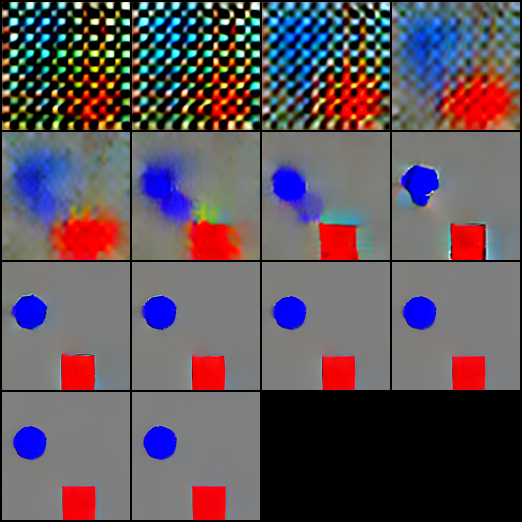

In [21]:
alpha_t, sigma_t = pipeline.scheduler._sigma_to_alpha_sigma_t(pipeline.scheduler.sigmas)
sample_i = 12
noise_pred_traj[:, sample_i] # 14, 4, 16, 16
latents_traj[:, sample_i] # 15, 4, 16, 16
x0_pred_traj = (latents_traj[:-1, sample_i] - sigma_t[:-1, None, None, None] * noise_pred_traj[:, sample_i]) / alpha_t[:-1, None, None, None]
with torch.no_grad():
    x0_pred_traj_img_tsrs = pipeline.vae.decode(x0_pred_traj.half().cuda() / pipeline.vae.config.scaling_factor, return_dict=False)[0]

x0_pred_traj_imgs = pipeline.image_processor.postprocess(x0_pred_traj_img_tsrs, output_type="pil")
display(pil_images_to_grid(x0_pred_traj_imgs))

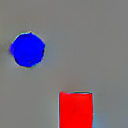

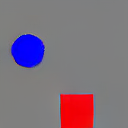

In [22]:
display(pil_images_to_grid([x0_pred_traj_imgs[0]]))
display(pil_images_to_grid([x0_pred_traj_imgs[4]]))
display(pil_images_to_grid([x0_pred_traj_imgs[8]]))
display(pil_images_to_grid([x0_pred_traj_imgs[12]]))

In [26]:
attn_map_stacked = [th.stack(attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'], dim=0) for layer_i in range(len(model.blocks))]
attn_map_stacked = th.stack(attn_map_stacked, dim=0)
cross_attn_map_stacked = [th.stack(attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'], dim=0) for layer_i in range(len(model.blocks))]
cross_attn_map_stacked = th.stack(cross_attn_map_stacked, dim=0)
print("attn_map_stacked.shape: ", attn_map_stacked.shape) # (num_layers, num_steps, num_images * 2, num_heads, num_tokens, num_tokens)
print("cross_attn_map_stacked.shape: ", cross_attn_map_stacked.shape) # (num_layers, num_steps, num_images * 2, num_heads, num_tokens, num_word_tokens)

attn_map_stacked.shape:  torch.Size([6, 14, 32, 6, 64, 64])
cross_attn_map_stacked.shape:  torch.Size([6, 14, 32, 6, 64, 20])


In [29]:
def create_multi_hot_token_mask_CLIP(tokens, target_words, seq_len=None):
    mask = th.zeros(len(tokens) if seq_len is None else seq_len, dtype=th.bool)
    for i, token in enumerate(tokens):
        # Remove the special prefix if present
        clean_token = token.replace('▁', '') if token.startswith('▁') else token
        if clean_token.endswith('</w>'):
            clean_token = clean_token.split('</w>')[0]
        if clean_token.startswith('<|') and clean_token.endswith('|>'):
            continue
        if clean_token in target_words:
            mask[i] = True
    return mask


def CLIP_tokenizer_split(tokenizer, prompt, max_length=20):
    # Create multi-hot masks for different types of words
    text_tokens_and_mask = tokenizer(
        prompt,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    input_ids = text_tokens_and_mask['input_ids']
    if input_ids.ndim == 2:
        input_ids = input_ids[0]
    token_splits = [tokenizer.decode(i) for i in input_ids]
    return token_splits

token_splits = CLIP_tokenizer_split(pipeline.tokenizer, prompt)

In [28]:
from circuit_toolkit.plot_utils import saveallforms
figdir = "/n/home12/binxuwang/Github/DiffusionObjectRelation/Figures/DiT_CLIP_L0H5_L0H2_dissection"
os.makedirs(figdir, exist_ok=True)

In [33]:
cross_attn_map_stacked.shape

torch.Size([6, 14, 32, 6, 64, 20])

In [34]:
i_layer = 0
j_head = 5
k_step = 5
n_images = 16
token_splits = CLIP_tokenizer_split(pipeline.tokenizer, prompt)
token_mask = create_multi_hot_token_mask_CLIP(token_splits, ["below"], seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, k_step, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape

torch.Size([16, 64])

In [35]:
prompt = "red square is below and to the right of the blue circle"

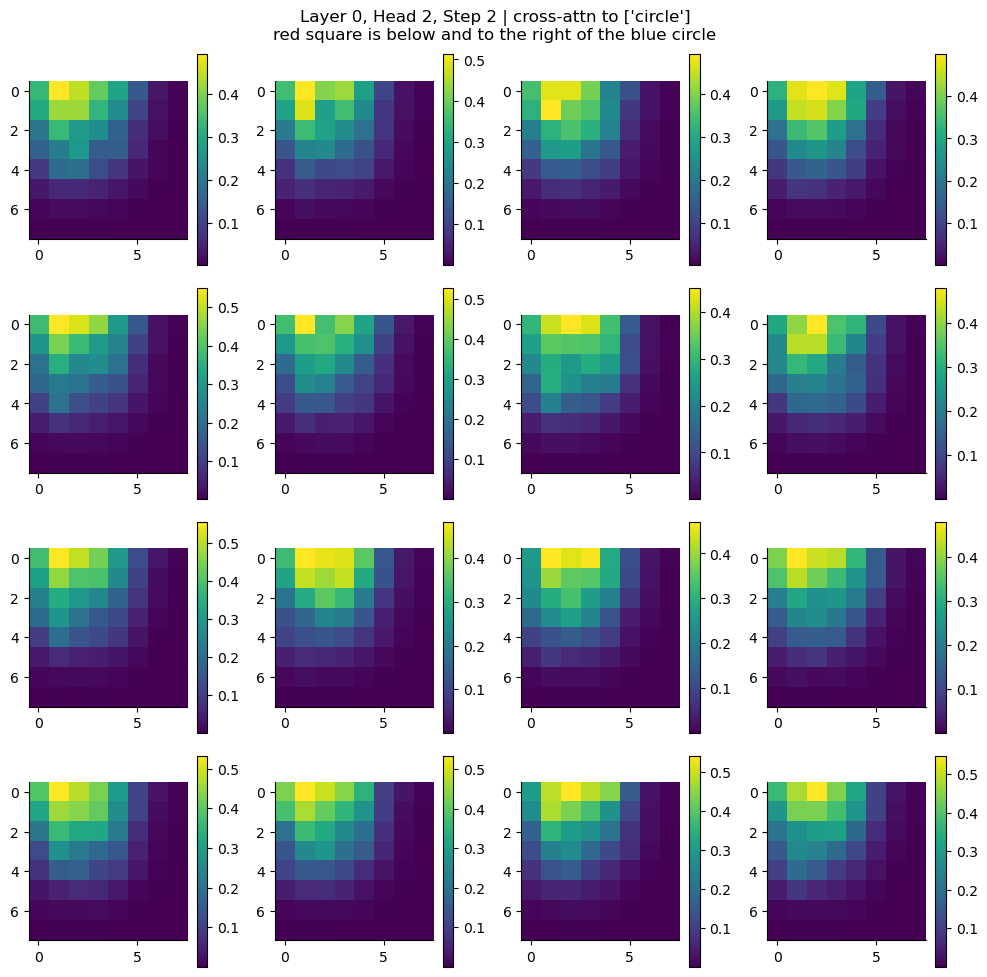

In [39]:
i_layer = 0
j_head = 2
k_step = 2
n_images = 16
target_words = ["circle"]
token_mask = create_multi_hot_token_mask_CLIP(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, k_step, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.flatten()
for i_sample in range(16):
    plt.sca(axs[i_sample])
    plt.imshow(L2H8_cross_attn_maps[i_sample, :].view(8, 8))
    plt.colorbar()
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Step {k_step} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
plt.show()

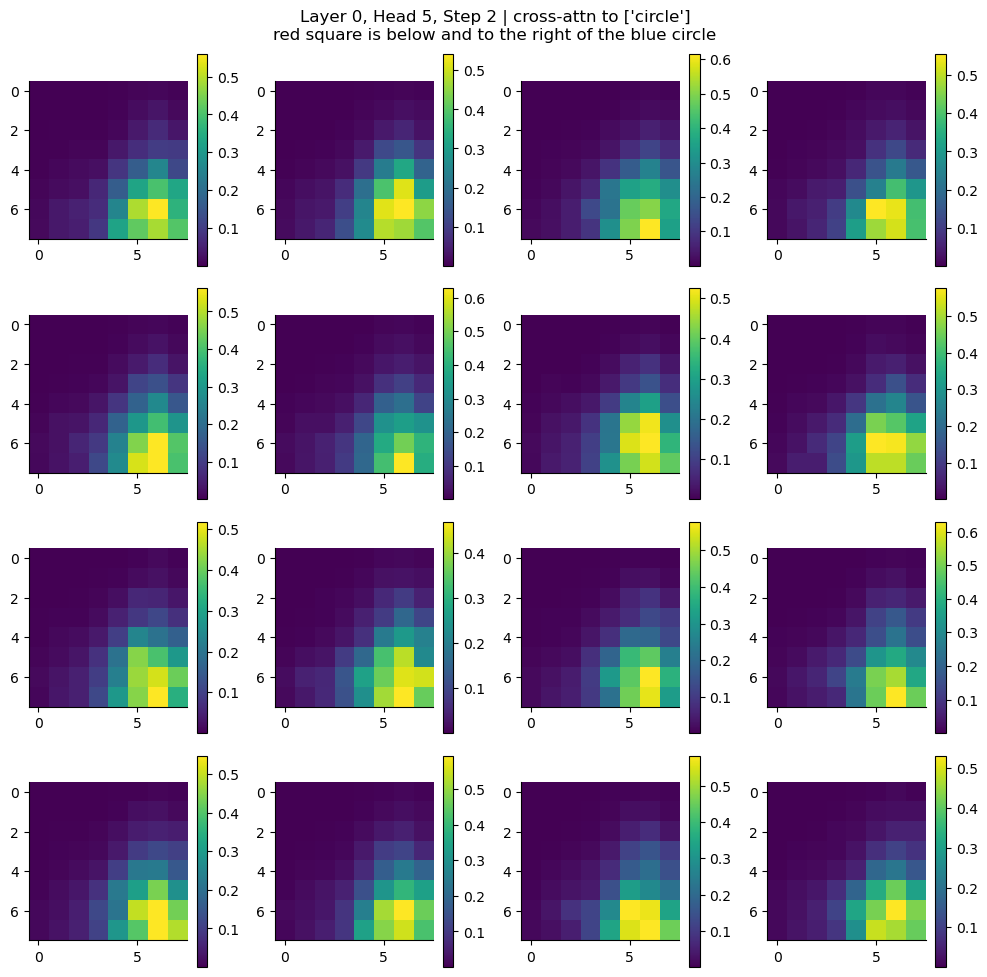

In [38]:
i_layer = 0
j_head = 5
k_step = 2
n_images = 16
target_words = ["circle"]
token_mask = create_multi_hot_token_mask_CLIP(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, k_step, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.flatten()
for i_sample in range(16):
    plt.sca(axs[i_sample])
    plt.imshow(L2H8_cross_attn_maps[i_sample, :].view(8, 8))
    plt.colorbar()
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Step {k_step} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
plt.show()

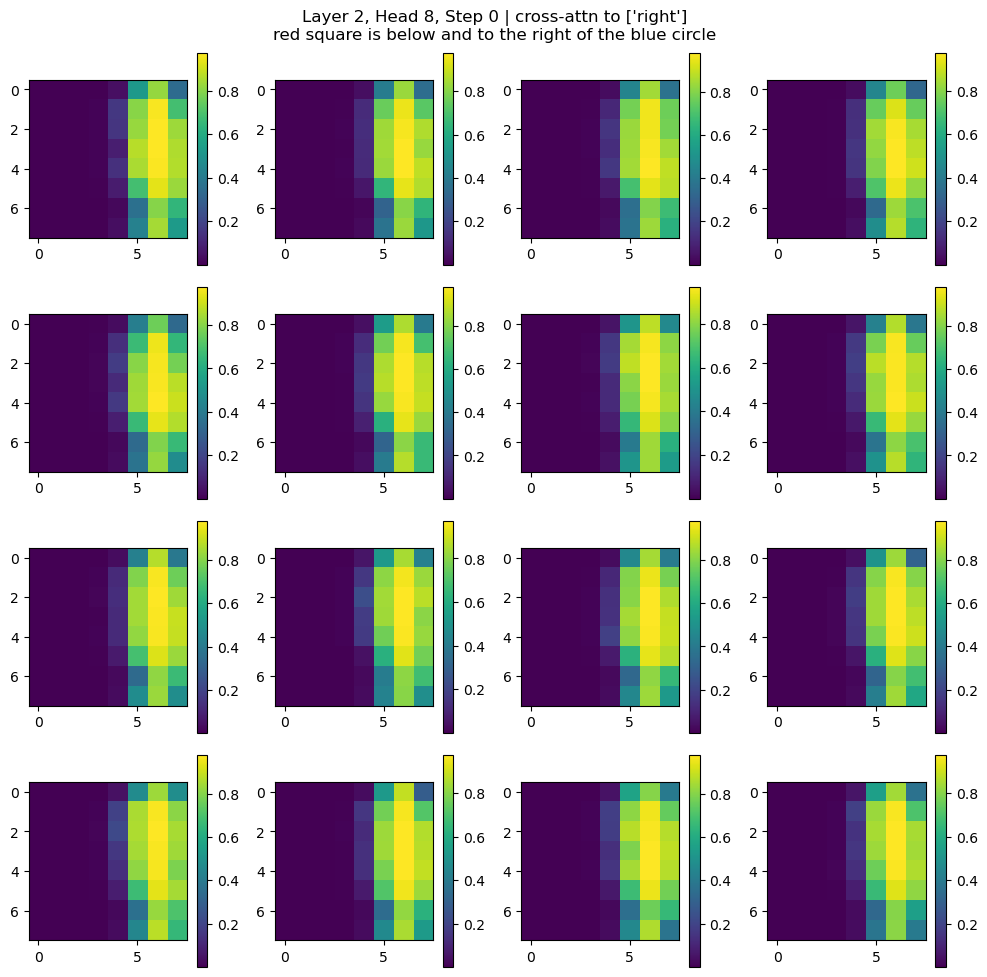

In [41]:
i_layer = 2
j_head = 8
k_step = 0
n_images = 16
target_words = ["right"]
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, k_step, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.flatten()
for i_sample in range(16):
    plt.sca(axs[i_sample])
    plt.imshow(L2H8_cross_attn_maps[i_sample, :].view(8, 8))
    plt.colorbar()
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Step {k_step} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
plt.show()

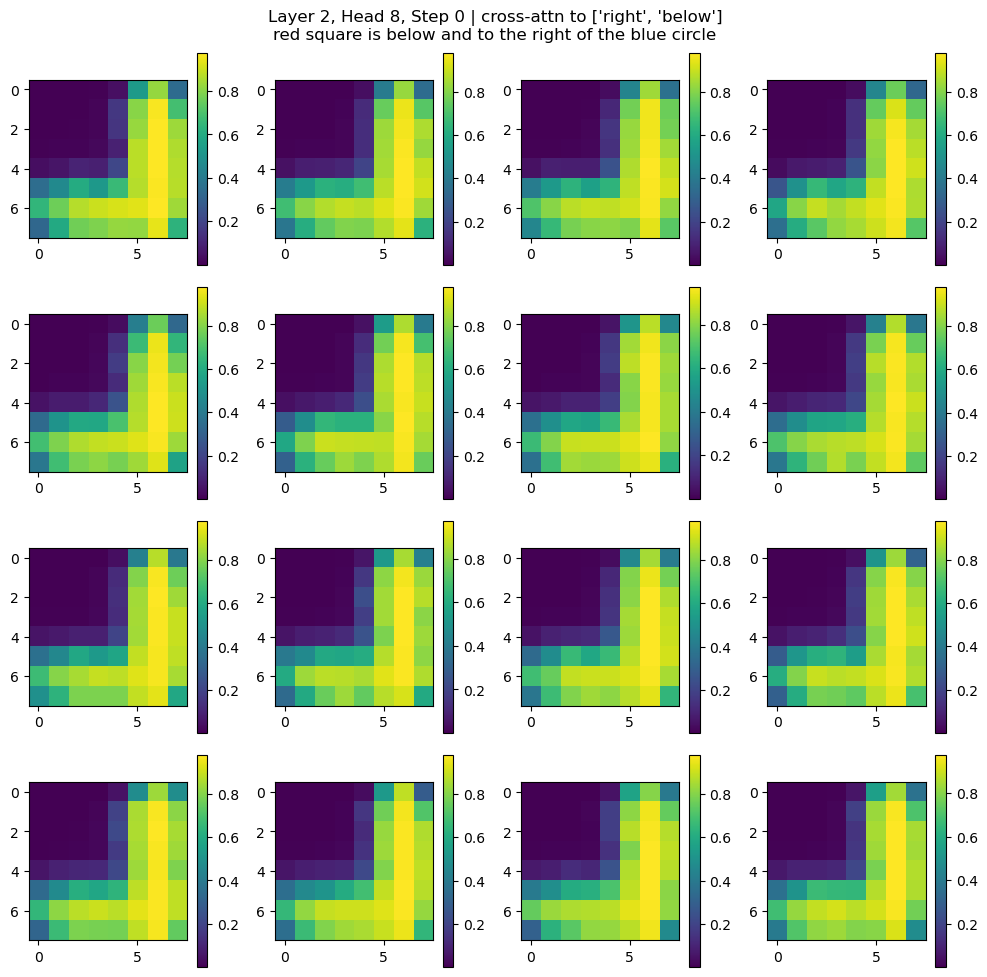

In [40]:
i_layer = 2
j_head = 8
k_step = 0
n_images = 16
target_words = ["right", "below"]
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, k_step, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.flatten()
for i_sample in range(16):
    plt.sca(axs[i_sample])
    plt.imshow(L2H8_cross_attn_maps[i_sample, :].view(8, 8))
    plt.colorbar()
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Step {k_step} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
plt.show()

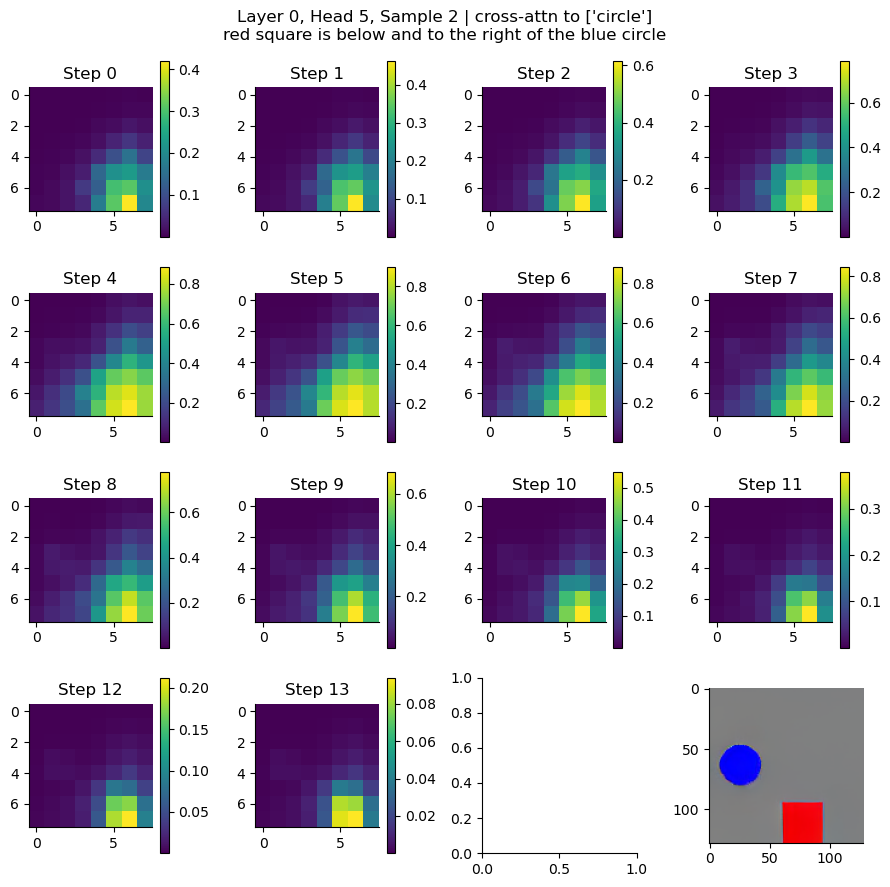

In [41]:
i_layer = 0
j_head = 5
# k_step = 0
n_images = 16
i_sample = 2
target_words = ["circle"]
token_mask = create_multi_hot_token_mask_CLIP(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
saveallforms(figdir, f"L{i_layer}H{j_head}S{i_sample}_cross_attn_maps_to_{'_'.join(target_words)}_prompt_{prompt.replace(' ', '_')}")
plt.show()

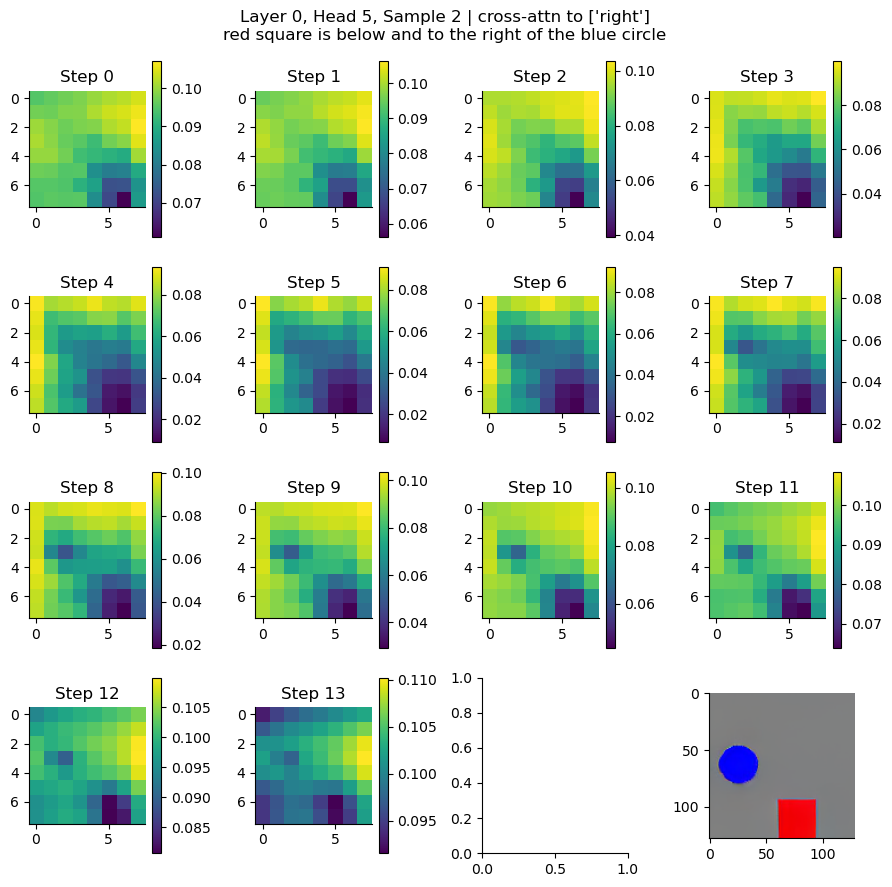

In [44]:
i_layer = 0
j_head = 5
# k_step = 0
n_images = 16
i_sample = 2
target_words = ["right"]
token_mask = create_multi_hot_token_mask_CLIP(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
saveallforms(figdir, f"L{i_layer}H{j_head}S{i_sample}_cross_attn_maps_to_{'_'.join(target_words)}_prompt_{prompt.replace(' ', '_')}")
plt.show()

In [ ]:
figdir

In [40]:
i_layer = 0
j_head = 2
# k_step = 0
n_images = 16
i_sample = 2
target_words = ["circle"]
token_mask = create_multi_hot_token_mask_CLIP(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
saveallforms(figdir, f"L{i_layer}H{j_head}S{i_sample}_cross_attn_maps_to_{'_'.join(target_words)}_prompt_{prompt.replace(' ', '_')}")
plt.show()

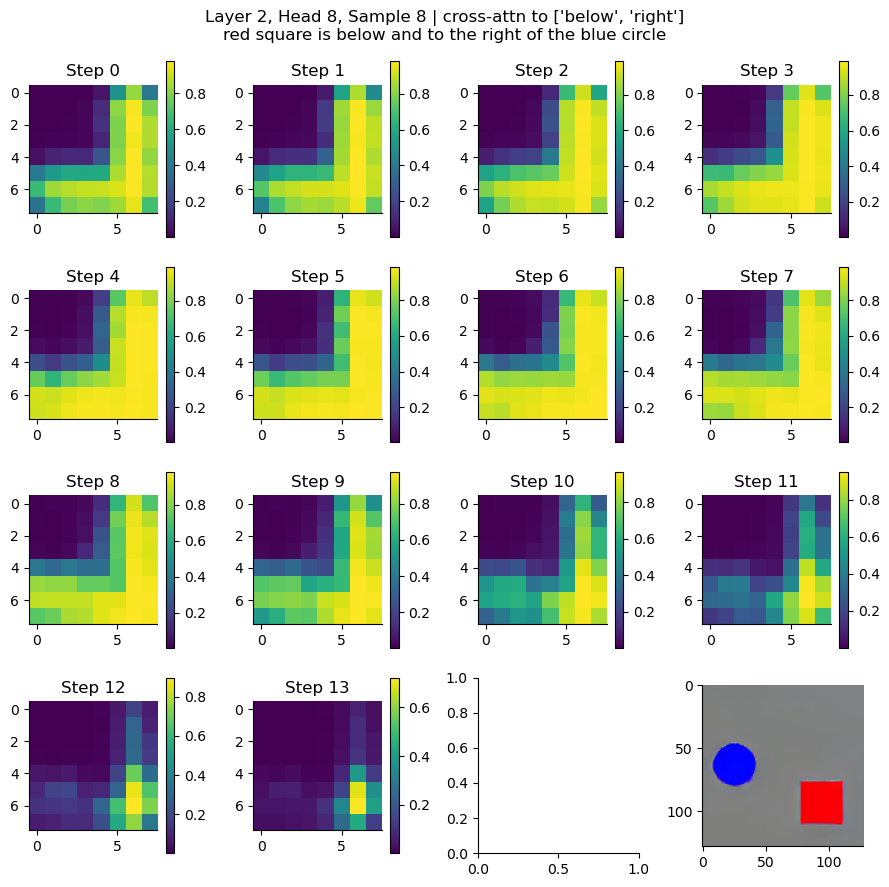

In [24]:
i_layer = 2
j_head = 8
# k_step = 0
n_images = 16
target_words = ["below", "right"]
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
i_sample = 8
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
# for k in range(14, 16):
#     plt.sca(axs[k_step])
#     plt.axis("off")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
saveallforms(figdir, f"L{i_layer}H{j_head}S{i_sample}_cross_attn_maps_to_{'_'.join(target_words)}_prompt_{prompt.replace(' ', '_')}")
plt.show()

In [25]:
i_layer = 2
j_head = 8
# k_step = 0
i_sample = 12
n_images = 16
target_words = ["below", "right"]
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
saveallforms(figdir, f"L{i_layer}H{j_head}S{i_sample}_cross_attn_maps_to_{'_'.join(target_words)}_prompt_{prompt.replace(' ', '_')}")
plt.show()

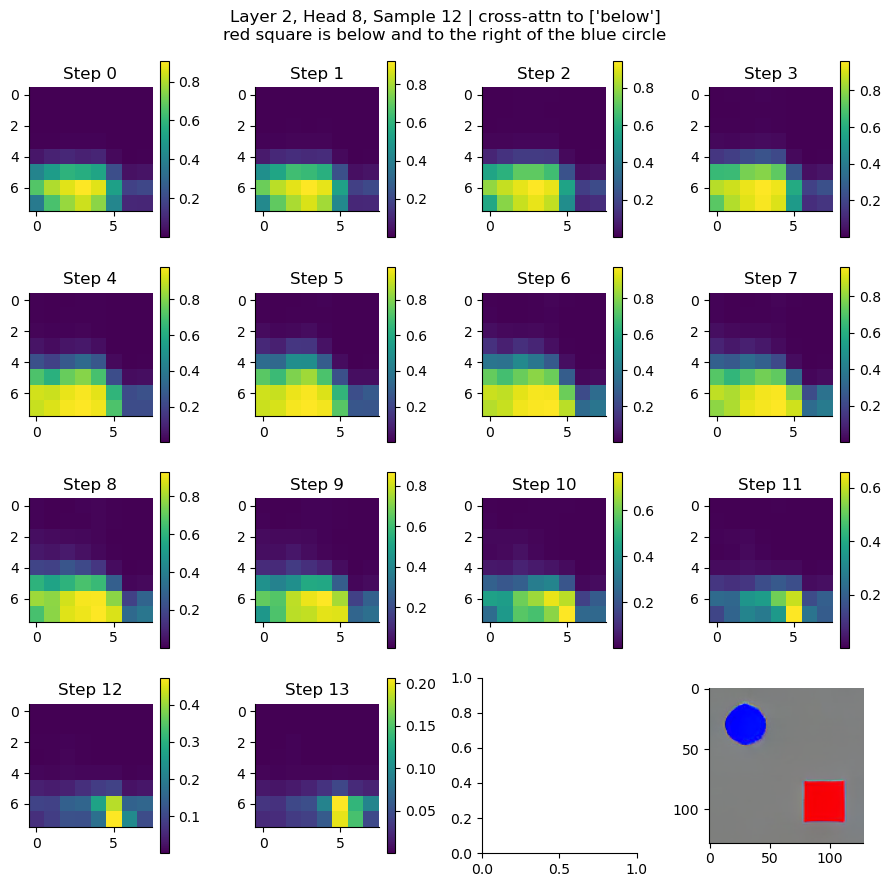

In [26]:
i_layer = 2
j_head = 8
# k_step = 0
n_images = 16
target_words = ["below",]
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
i_sample = 12
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
saveallforms(figdir, f"L{i_layer}H{j_head}S{i_sample}_cross_attn_maps_to_{'_'.join(target_words)}_prompt_{prompt.replace(' ', '_')}")
plt.show()

In [27]:
i_layer = 2
j_head = 8
# k_step = 0
n_images = 16
target_words = ["right",]
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
i_sample = 12
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
saveallforms(figdir, f"L{i_layer}H{j_head}S{i_sample}_cross_attn_maps_to_{'_'.join(target_words)}_prompt_{prompt.replace(' ', '_')}")
plt.show()

### 

### Above and left

torch.Size([32, 20, 4096])
torch.Size([32, 20])


  0%|          | 0/14 [00:00<?, ?it/s]

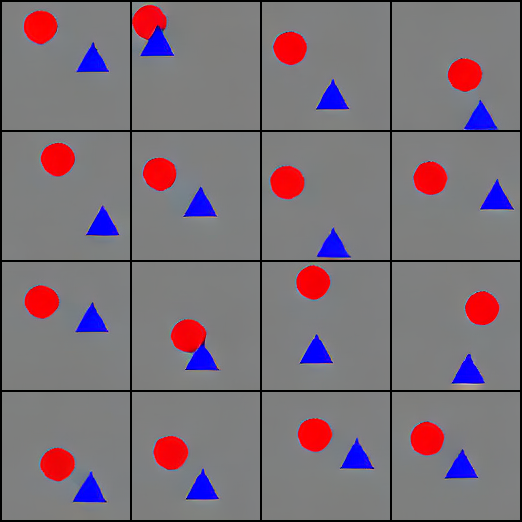

In [54]:
attnvis_store.clear_activation()
prompt = "red circle is above and to the left of the blue triangle"
output = pipeline(prompt, 
        num_inference_steps=14,
        max_sequence_length=20, 
        num_images_per_prompt=16,
        return_sample_pred_traj=True,
        device="cuda")
pred_traj, latents_traj, t_traj = output[1], output[2], output[3]
display(pil_images_to_grid(output[0].images))

In [55]:
attn_map_stacked = [th.stack(attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'], dim=0) for layer_i in range(12)]
attn_map_stacked = th.stack(attn_map_stacked, dim=0)
cross_attn_map_stacked = [th.stack(attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'], dim=0) for layer_i in range(12)]
cross_attn_map_stacked = th.stack(cross_attn_map_stacked, dim=0)
print("attn_map_stacked.shape: ", attn_map_stacked.shape) # (num_layers, num_steps, num_images * 2, num_heads, num_tokens, num_tokens)
print("cross_attn_map_stacked.shape: ", cross_attn_map_stacked.shape) # (num_layers, num_steps, num_images * 2, num_heads, num_tokens, num_word_tokens)

attn_map_stacked.shape:  torch.Size([12, 14, 32, 12, 64, 64])
cross_attn_map_stacked.shape:  torch.Size([12, 14, 32, 12, 64, 20])


In [61]:
prompt

'red circle is above and to the left of the blue triangle'

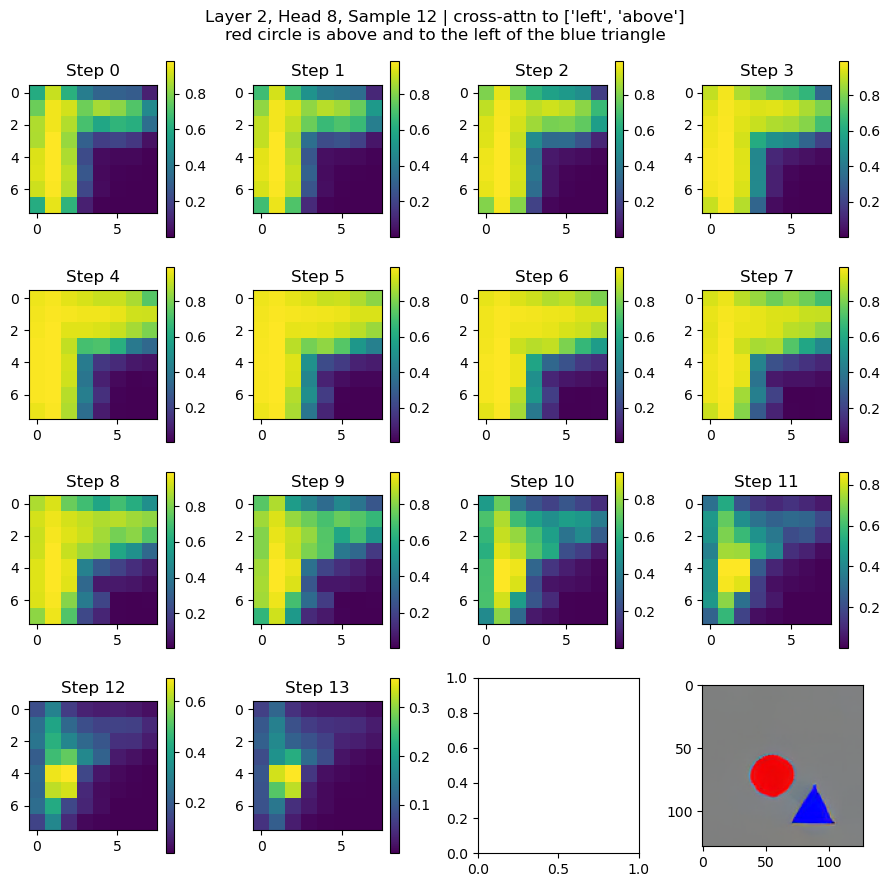

In [58]:
i_layer = 2
j_head = 8
# k_step = 0
n_images = 16
target_words = ["left", "above",]
token_splits = pipeline.tokenizer.tokenize(prompt)
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
i_sample = 12
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
plt.show()

In [59]:
i_layer = 2
j_head = 8
# k_step = 0
n_images = 16
target_words = ["left", ]
token_splits = pipeline.tokenizer.tokenize(prompt)
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
i_sample = 12
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
plt.show()

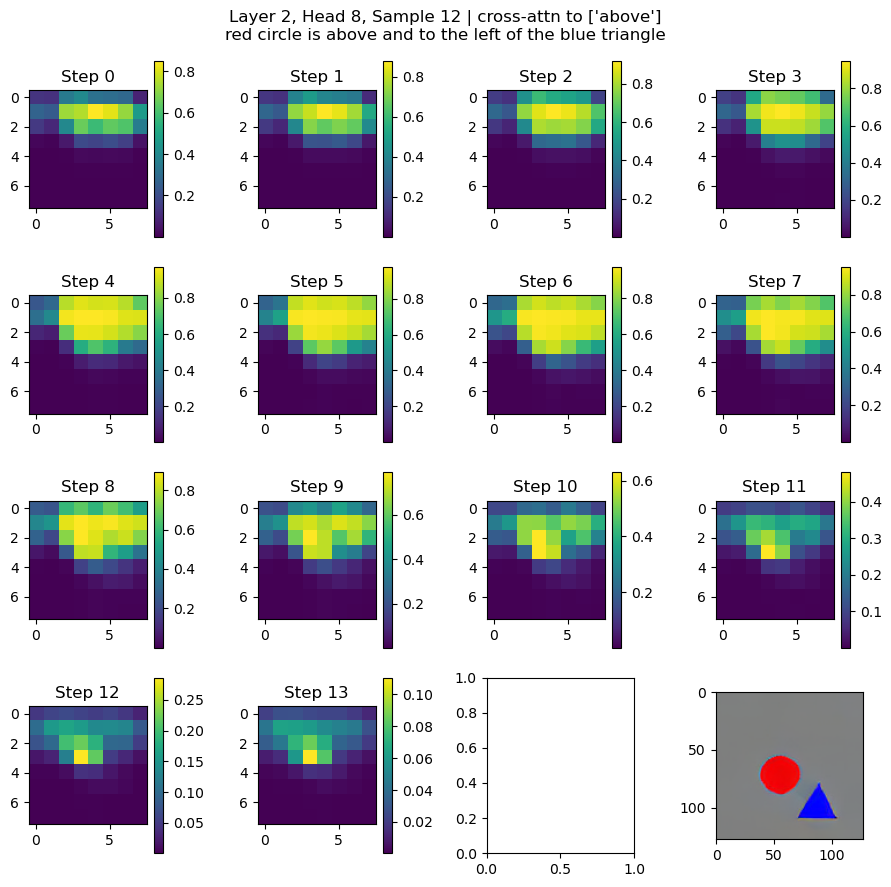

In [60]:
i_layer = 2
j_head = 8
# k_step = 0
n_images = 16
target_words = ["above", ]
token_splits = pipeline.tokenizer.tokenize(prompt)
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
i_sample = 12
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
plt.show()

### Ambiguous

torch.Size([32, 20, 4096])
torch.Size([32, 20])


  0%|          | 0/14 [00:00<?, ?it/s]

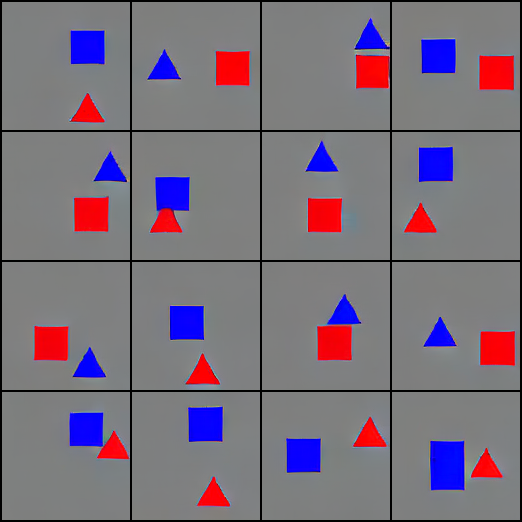

In [62]:
attnvis_store.clear_activation()
prompt = "red square is above and below and to the left of and right of the blue triangle"
output = pipeline(prompt, 
        num_inference_steps=14,
        max_sequence_length=20, 
        num_images_per_prompt=16,
        return_sample_pred_traj=True,
        device="cuda")
pred_traj, latents_traj, t_traj = output[1], output[2], output[3]
display(pil_images_to_grid(output[0].images))

In [63]:
attn_map_stacked = [th.stack(attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'], dim=0) for layer_i in range(12)]
attn_map_stacked = th.stack(attn_map_stacked, dim=0)
cross_attn_map_stacked = [th.stack(attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'], dim=0) for layer_i in range(12)]
cross_attn_map_stacked = th.stack(cross_attn_map_stacked, dim=0)
print("attn_map_stacked.shape: ", attn_map_stacked.shape) # (num_layers, num_steps, num_images * 2, num_heads, num_tokens, num_tokens)
print("cross_attn_map_stacked.shape: ", cross_attn_map_stacked.shape) # (num_layers, num_steps, num_images * 2, num_heads, num_tokens, num_word_tokens)

attn_map_stacked.shape:  torch.Size([12, 14, 32, 12, 64, 64])
cross_attn_map_stacked.shape:  torch.Size([12, 14, 32, 12, 64, 20])


In [68]:
prompt

'red square is above and below and to the left of and right of the blue triangle'

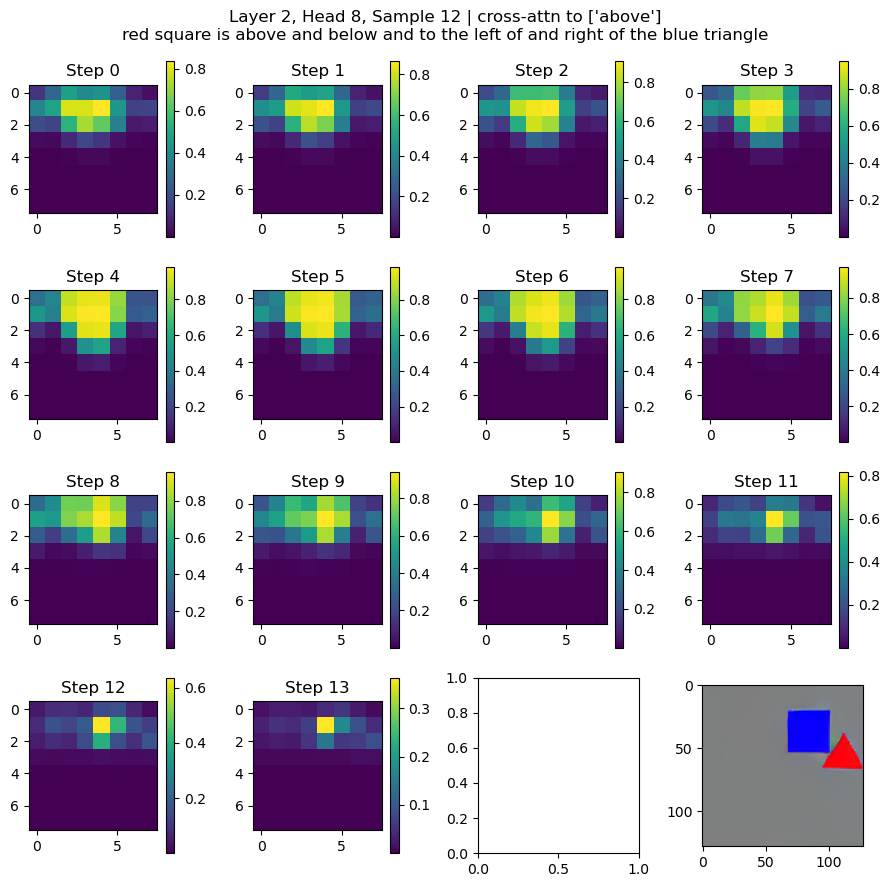

In [64]:
i_layer = 2
j_head = 8
# k_step = 0
n_images = 16
target_words = ["above", ]
token_splits = pipeline.tokenizer.tokenize(prompt)
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
i_sample = 12
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
plt.show()

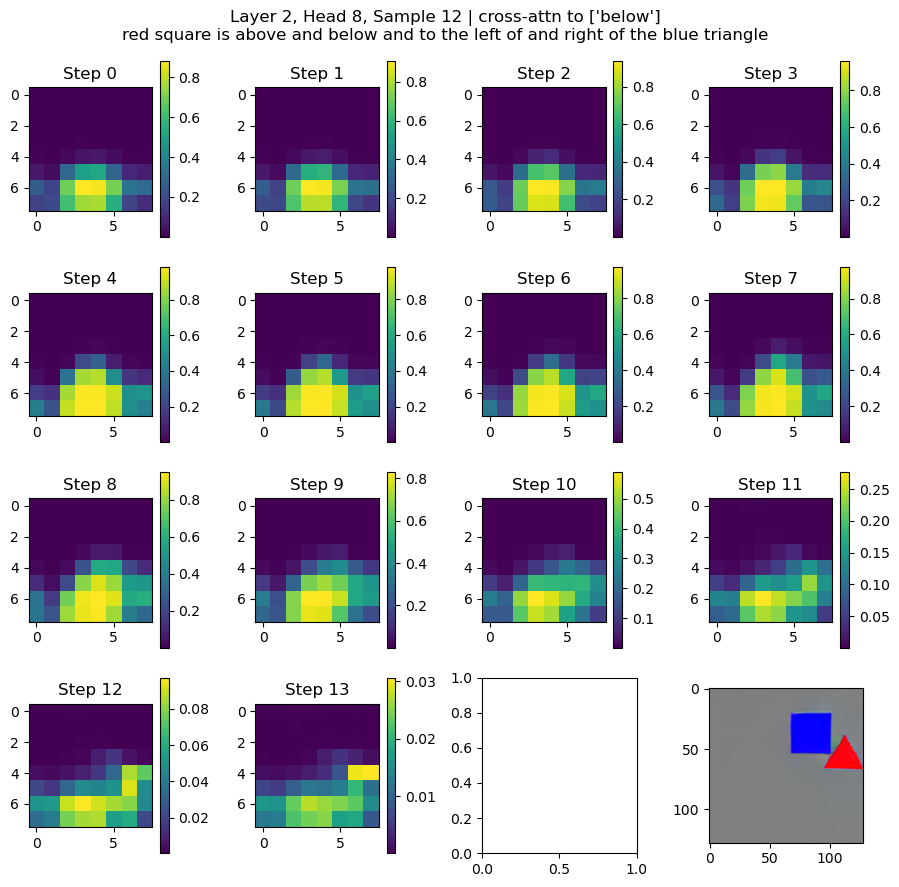

In [65]:
i_layer = 2
j_head = 8
# k_step = 0
n_images = 16
target_words = ["below", ]
token_splits = pipeline.tokenizer.tokenize(prompt)
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
i_sample = 12
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
plt.show()

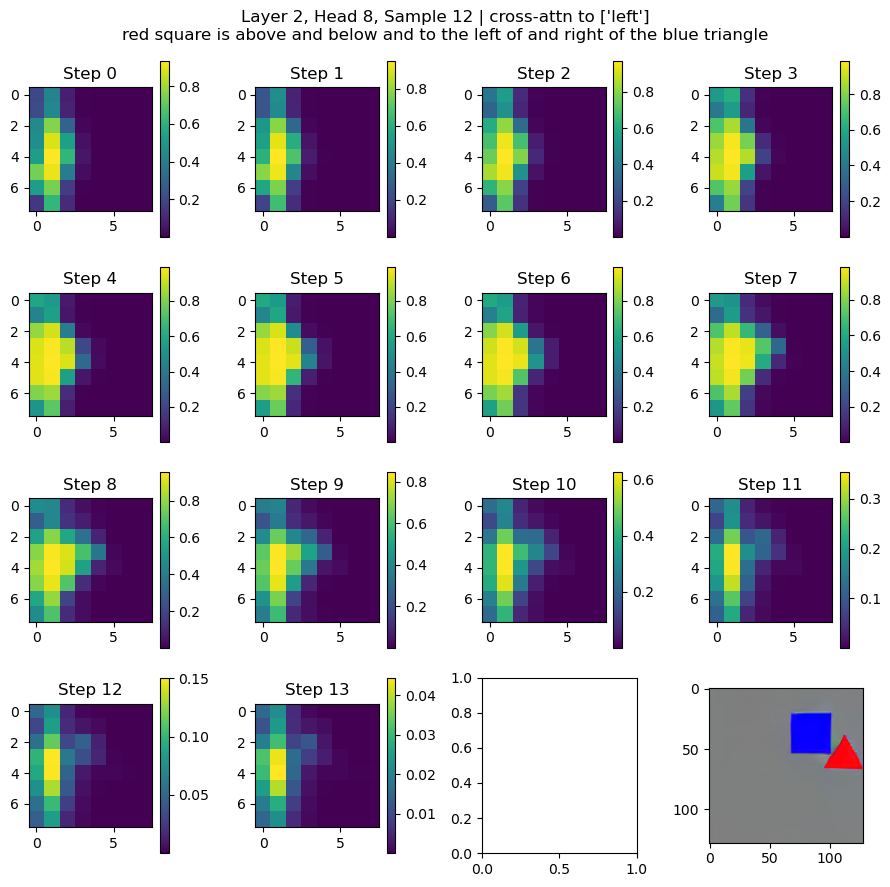

In [66]:
i_layer = 2
j_head = 8
# k_step = 0
n_images = 16
target_words = ["left", ]
token_splits = pipeline.tokenizer.tokenize(prompt)
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
i_sample = 12
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
plt.show()

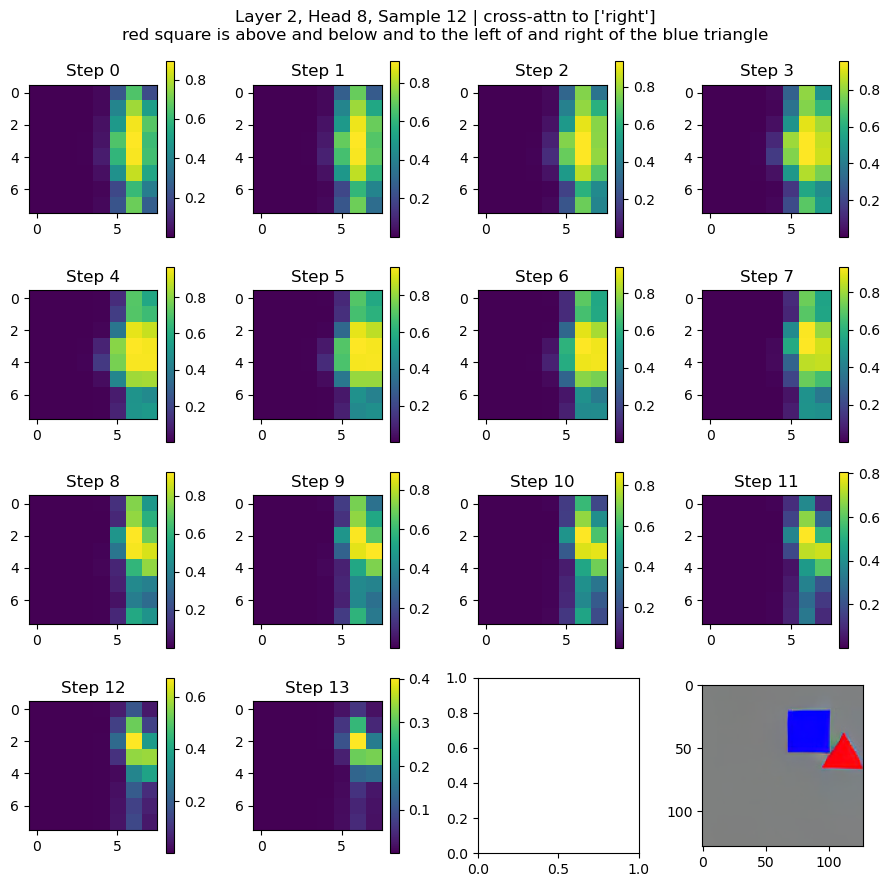

In [67]:
i_layer = 2
j_head = 8
# k_step = 0
n_images = 16
target_words = ["right", ]
token_splits = pipeline.tokenizer.tokenize(prompt)
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
i_sample = 12
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
plt.show()

### Attention QK checking of L2H8

In [31]:
from diffusion.model.nets.PixArt import get_2d_sincos_pos_embed

In [32]:
hidden_size = 768
base_size = 16 // 2
head_dim = hidden_size // 12
head_idx = 8
device = "cpu"
relation_words = ["above", "below", "right", "left", ]
token_ids = pipeline.tokenizer.encode(" ".join(relation_words), max_length=20, truncation=False)
word_embeds, attn_mask = pipeline.text_encoder(token_ids)
word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
word_embed_2k = pipeline.transformer.transformer_blocks[2].attn2.to_k(word_embeds_proj)
word_embed_2k_h8 = word_embed_2k[:, head_idx*head_dim:(head_idx+1)*head_dim]
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
pos_embed_2q = pipeline.transformer.transformer_blocks[2].attn2.to_q(pos_embed.half().cuda())
pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]

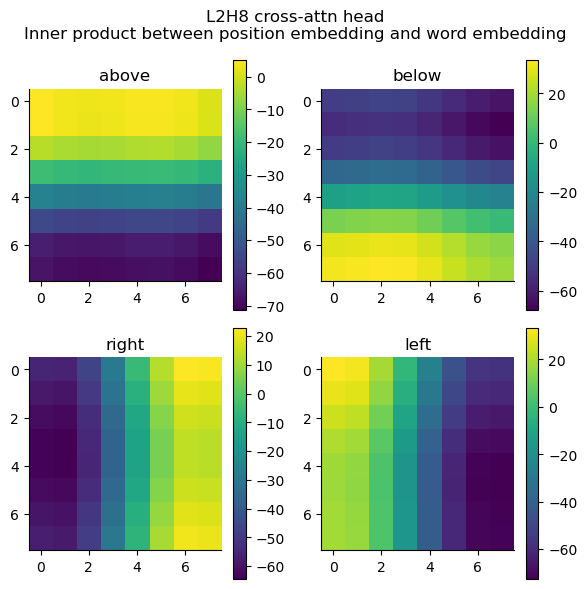

In [33]:
figh, axs = plt.subplots(2, 2, figsize=(6, 6))
axs = axs.flatten()
for i_word in range(len(relation_words)):
    plt.sca(axs[i_word])
    inner_prod = pos_embed_2q_h8 @ word_embed_2k_h8[i_word:i_word+1].T
    plt.imshow(inner_prod.view(8, 8).detach().cpu().numpy())
    plt.colorbar()
    plt.title(relation_words[i_word])
plt.suptitle(f"L2H8 cross-attn head\nInner product between position embedding and word embedding")
plt.tight_layout()
saveallforms(figdir, "L2H8_cross_attn_head_inprod_between_img_pos_embd_and_word_embed_MLP")
plt.show()

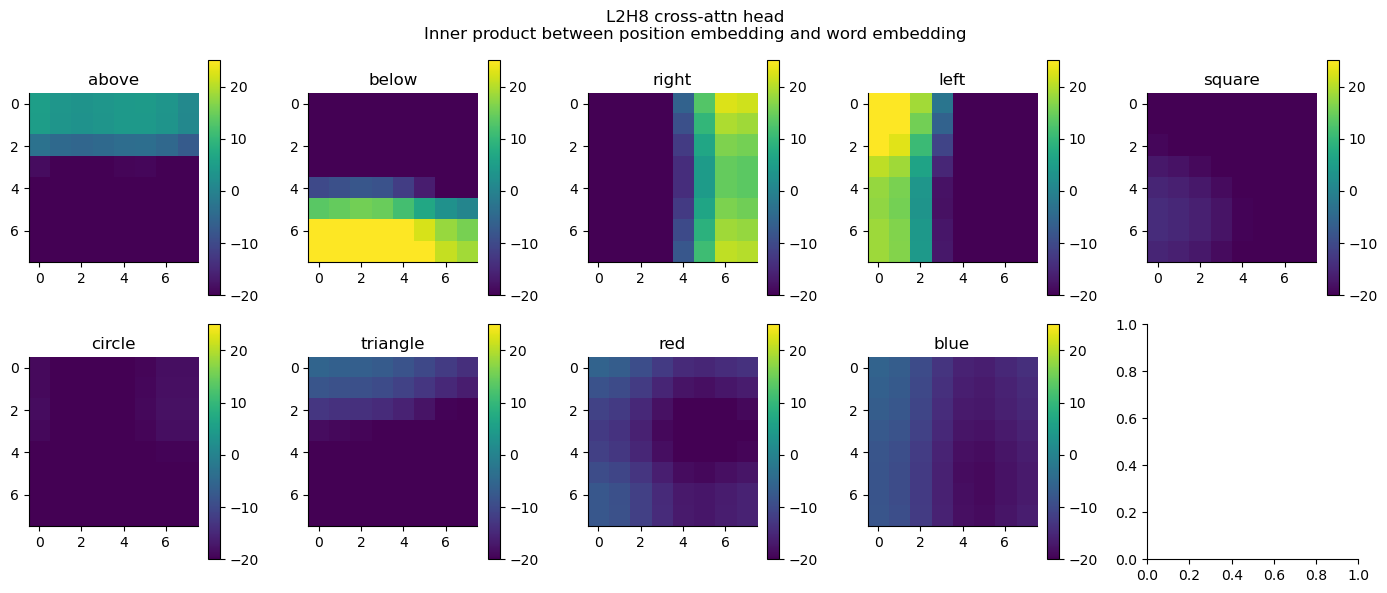

In [34]:
hidden_size = 768
base_size = 16 // 2
head_dim = hidden_size // 12
head_idx = 8
device = "cpu"
relation_words = ["above", "below", "right", "left", "square", "circle", "triangle", "red", "blue", ]
token_ids = pipeline.tokenizer.encode(" ".join(relation_words), max_length=20, truncation=False)
word_embeds, attn_mask = pipeline.text_encoder(token_ids)
word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
word_embed_2k = pipeline.transformer.transformer_blocks[2].attn2.to_k(word_embeds_proj)
word_embed_2k_h8 = word_embed_2k[:, head_idx*head_dim:(head_idx+1)*head_dim]
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
pos_embed_2q = pipeline.transformer.transformer_blocks[2].attn2.to_q(pos_embed.half().cuda())
pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
figh, axs = plt.subplots(2, 5, figsize=(14, 6))
axs = axs.flatten()
inner_prods = (pos_embed_2q_h8 @ word_embed_2k_h8.T).detach().cpu()
for i_word in range(len(relation_words)):
    plt.sca(axs[i_word])
    inner_prod = inner_prods[:, i_word:i_word+1]
    plt.imshow(inner_prod.view(8, 8).detach().cpu().numpy(), vmax=25, vmin=-20)
    plt.colorbar()
    plt.title(relation_words[i_word])
plt.suptitle(f"L2H8 cross-attn head\nInner product between position embedding and word embedding")
plt.tight_layout()
saveallforms(figdir, "L2H8_cross_attn_head_inprod_between_img_pos_embd_and_word_embed_MLP_all_words")
plt.show()

In [ ]:
hidden_size = 768
base_size = 16 // 2
head_dim = hidden_size // 12
layer_idx = 2
head_idx = 8
device = "cpu"
relation_words = ["above", "below", "right", "left", "square", "circle", "triangle", "red", "blue", ][::-1]
token_ids = pipeline.tokenizer.encode(" ".join(relation_words), max_length=20, truncation=False)
word_embeds, attn_mask = pipeline.text_encoder(token_ids)
word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(word_embeds_proj)
word_embed_2k_h8 = word_embed_2k[:, head_idx*head_dim:(head_idx+1)*head_dim]
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
figh, axs = plt.subplots(2, 5, figsize=(14, 6))
axs = axs.flatten()
inner_prods = (pos_embed_2q_h8 @ word_embed_2k_h8.T).detach().cpu()
for i_word in range(len(relation_words)):
    plt.sca(axs[i_word])
    inner_prod = inner_prods[:, i_word:i_word+1]
    plt.imshow(inner_prod.view(8, 8).detach().cpu().numpy(), vmax=25, vmin=-20)
    plt.colorbar()
    plt.title(relation_words[i_word])
plt.suptitle(f"L{layer_idx}H{head_idx} cross-attn head\nInner product between position embedding and word embedding")
plt.tight_layout()
plt.show()

L2H8


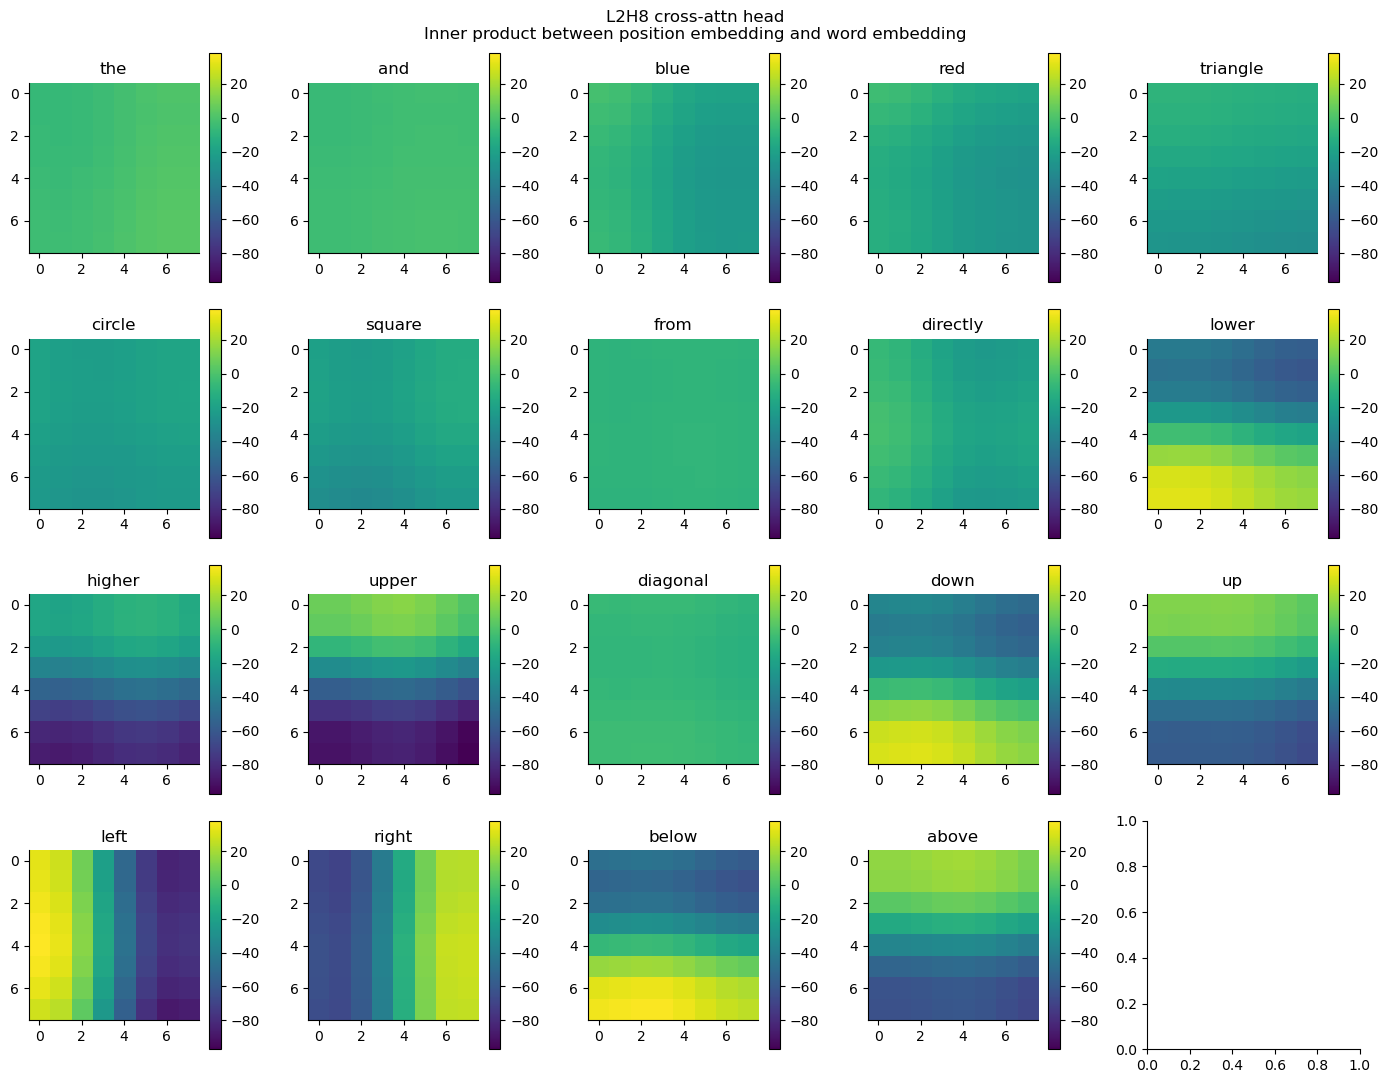

In [153]:
layer_idx = 2
head_idx = 8
print(f"L{layer_idx}H{head_idx}")
device = "cpu"
relation_words = ["above", "below", "right", "left", "up", "down", "diagonal", "upper", "higher", "lower", "directly", "from",
                "square", "circle", "triangle", "red", "blue", "and", "the", ][::-1]
token_ids = pipeline.tokenizer.encode(" ".join(relation_words), max_length=25, truncation=False)
word_embeds, attn_mask = pipeline.text_encoder(token_ids)
word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(word_embeds_proj)
word_embed_2k_h8 = word_embed_2k[:, head_idx*head_dim:(head_idx+1)*head_dim]
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
figh, axs = plt.subplots(4, 5, figsize=(14, 11))
axs = axs.flatten()
inner_prods = (pos_embed_2q_h8 @ word_embed_2k_h8.T).detach().cpu()
vmax = inner_prods.max().item()
vmin = inner_prods.min().item()
for i_word in range(len(relation_words)):
    plt.sca(axs[i_word])
    inner_prod = inner_prods[:, i_word:i_word+1]
    plt.imshow(inner_prod.view(8, 8).detach().cpu().numpy(), vmax=vmax, vmin=vmin)
    plt.colorbar()
    plt.title(relation_words[i_word])
plt.suptitle(f"L{layer_idx}H{head_idx} cross-attn head\nInner product between position embedding and word embedding")
plt.tight_layout()
# saveallforms(figdir, f"L{layer_idx}H{head_idx}_cross_attn_head_word_inner_prod.png")
plt.show()

### L4H3

In [35]:
prompt

'red square is below and to the right of the blue circle'

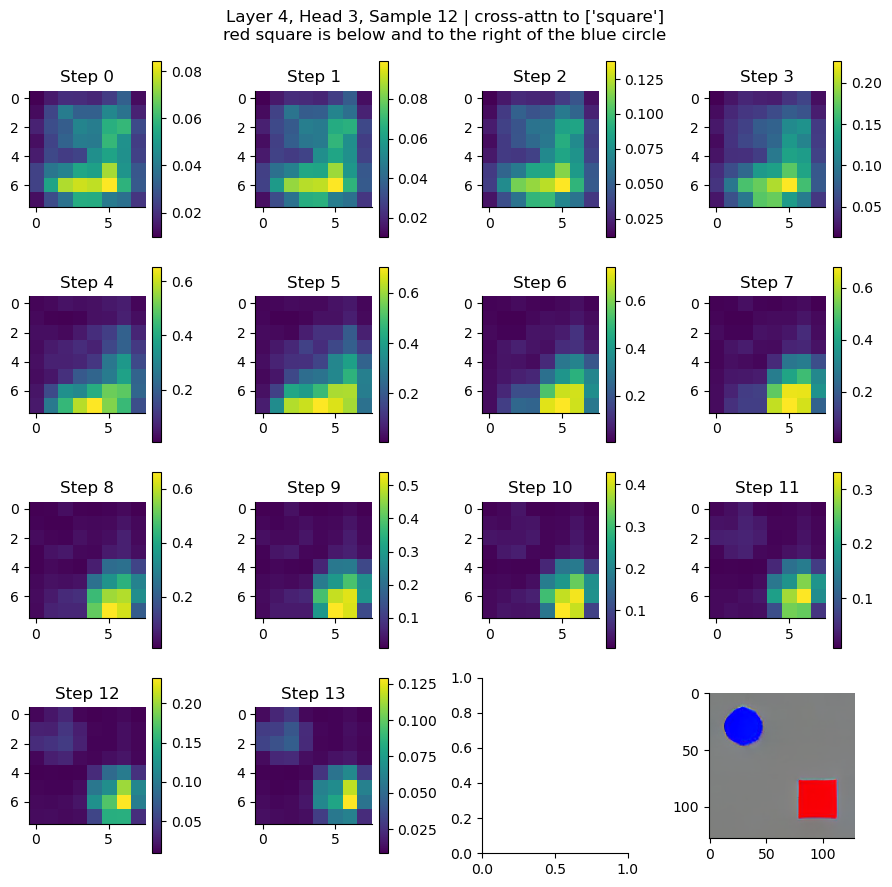

In [36]:
i_layer = 4
j_head = 3
# k_step = 0
i_sample = 12
n_images = 16
target_words = ["square",]
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
saveallforms(figdir, f"L{i_layer}H{j_head}S{i_sample}_cross_attn_maps_to_{'_'.join(target_words)}_prompt_{prompt.replace(' ', '_')}")
plt.show()

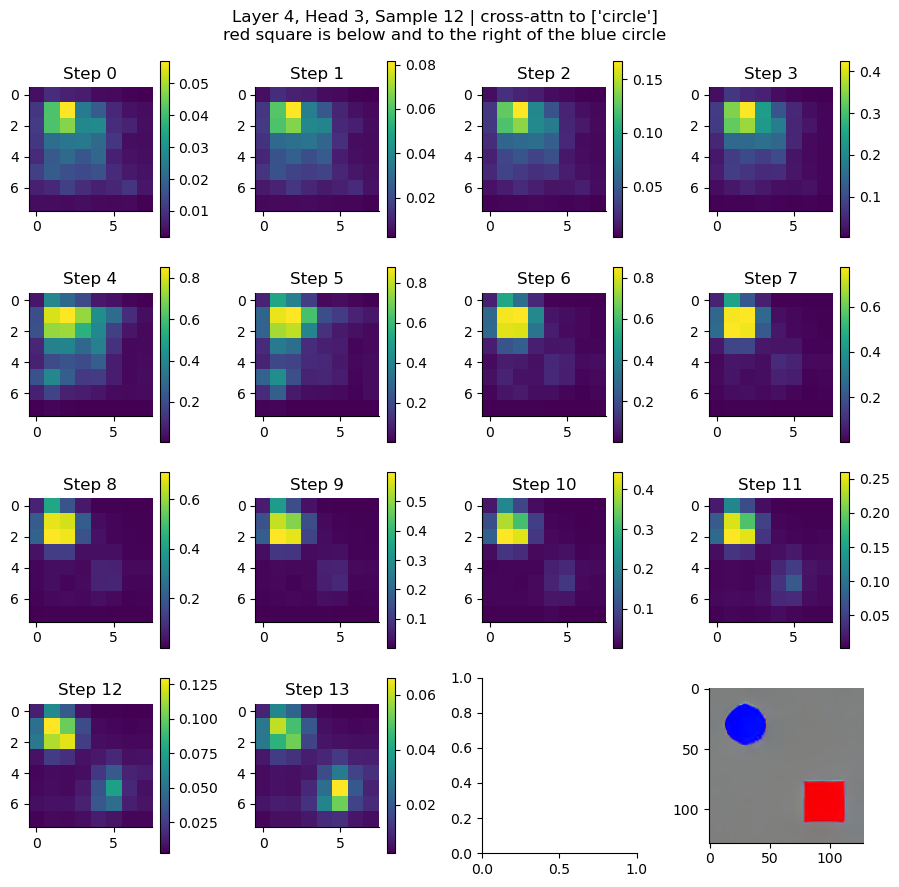

In [37]:
i_layer = 4
j_head = 3
# k_step = 0
i_sample = 12
n_images = 16
target_words = ["circle",]
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
saveallforms(figdir, f"L{i_layer}H{j_head}S{i_sample}_cross_attn_maps_to_{'_'.join(target_words)}_prompt_{prompt.replace(' ', '_')}")
plt.show()

### L2H8+L4H3

In [38]:
import math

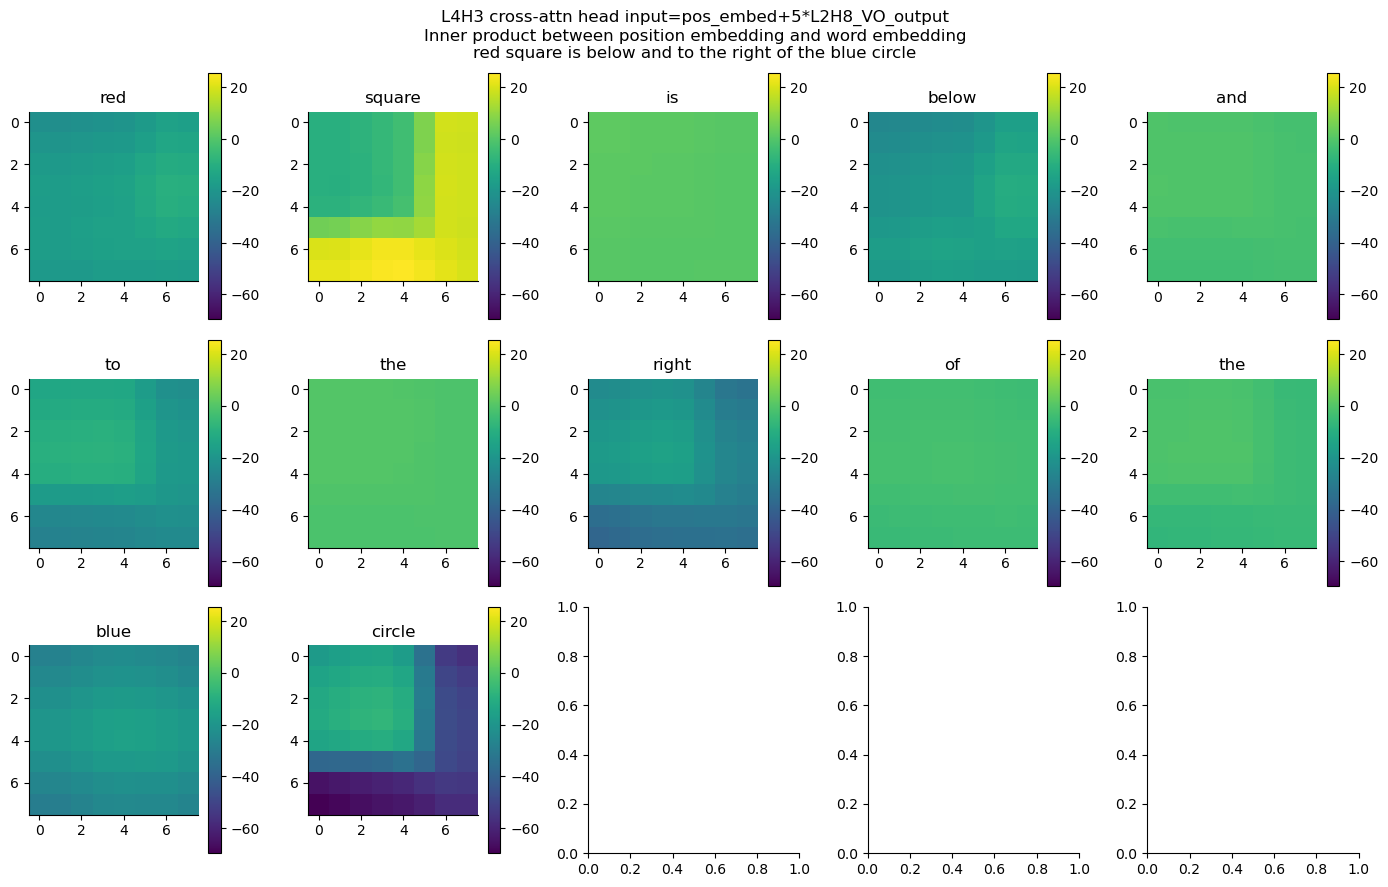

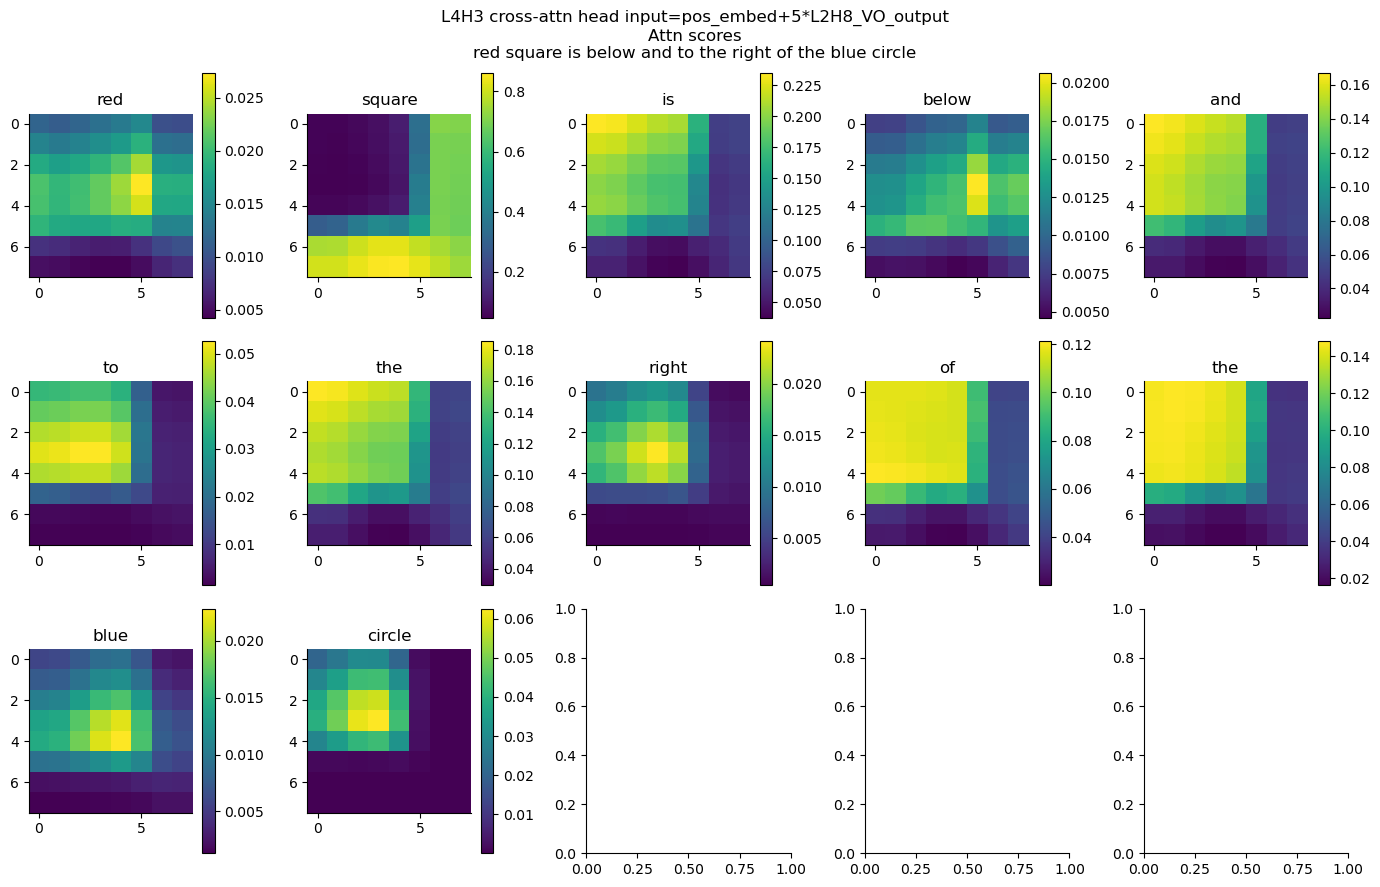

In [39]:
hidden_size = 768
base_size = 16 // 2
head_dim = hidden_size // 12
head_idx = 8
layer_idx = 2
device = "cpu"
prompt_tokenized = prompt.split(" ")
token_ids = pipeline.tokenizer.encode(" ".join(prompt_tokenized), max_length=20, truncation=False)
word_embeds, attn_mask = pipeline.text_encoder(token_ids)
with torch.no_grad():
    word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
    word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(word_embeds_proj)
    word_embed_2k_h8 = word_embed_2k[:, head_idx*head_dim:(head_idx+1)*head_dim]
    word_embed_2v = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_v(word_embeds_proj)
    word_embed_2v_h8 = word_embed_2v[:, head_idx*head_dim:(head_idx+1)*head_dim]
    word_embed_2v_h8_zero_pad = torch.zeros_like(word_embed_2v)
    word_embed_2v_h8_zero_pad[:, head_idx*head_dim:(head_idx+1)*head_dim] = word_embed_2v_h8
    word_embed_2v_h8_zero_pad_out = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_out[0](word_embed_2v_h8_zero_pad)
    # L2H8 cross-attn head
    pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
    pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
    pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
    pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
    inner_prods = (pos_embed_2q_h8 @ word_embed_2k_h8.T) / math.sqrt(head_dim)
    attn_scores = th.softmax(inner_prods.float(), dim=-1)
    attn_weighted_word_embed_2v_h8_zero_pad = attn_scores.half() @ word_embed_2v_h8_zero_pad
    final_L2H8_head_out = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_out[0](attn_weighted_word_embed_2v_h8_zero_pad)
word_embed_2v_h8_zero_pad_out.shape
final_L2H8_head_out


hidden_size = 768
base_size = 16 // 2
head_dim = hidden_size // 12
head_idx = 3
layer_idx = 4
device = "cpu"
alpha = 5
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
prompt_tokenized = prompt.split(" ")
token_ids = pipeline.tokenizer.encode(" ".join(prompt_tokenized), max_length=20, truncation=False)
word_embeds, attn_mask = pipeline.text_encoder(token_ids)
word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(word_embeds_proj)
word_embed_2k_h8 = word_embed_2k[:, head_idx*head_dim:(head_idx+1)*head_dim]
# implant the output of L2H8 VO output to the position encoding
pos_embed_plus_info = final_L2H8_head_out.unsqueeze(0) * alpha + pos_embed.half().cuda()
pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed_plus_info)
pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
inner_prods = (pos_embed_2q_h8 @ word_embed_2k_h8.T).detach().cpu()
figh, axs = plt.subplots(3, 5, figsize=(14, 9))
axs = axs.flatten()
vmax = inner_prods.max()
vmin = inner_prods.min()
for i_word in range(len(prompt_tokenized)):
    plt.sca(axs[i_word])
    inner_prod = inner_prods[:, i_word:i_word+1]
    plt.imshow(inner_prod.view(8, 8).detach().cpu().numpy(), vmax=vmax, vmin=vmin)
    plt.colorbar()
    plt.title(prompt_tokenized[i_word])
plt.suptitle(f"L4H3 cross-attn head input=pos_embed+{alpha}*L2H8_VO_output\nInner product between position embedding and word embedding\n{prompt}")
saveallforms(figdir, f"L4H3_cross_attn_head_inprod_img_pos_embd_plus_alpha{alpha}_L2H8_VO_output_and_word_embed_MLP_prompt_{prompt.replace(' ', '_')}")
plt.tight_layout()
plt.show()

attn_scores_L4H3 = (inner_prods / math.sqrt(head_dim)).softmax(dim=-1)
figh, axs = plt.subplots(3, 5, figsize=(14, 9))
axs = axs.flatten()
for i_word in range(len(prompt_tokenized)):
    plt.sca(axs[i_word])
    attn_scores_per_word = attn_scores_L4H3[:, i_word:i_word+1]
    plt.imshow(attn_scores_per_word.view(8, 8).detach().cpu().numpy())
    plt.colorbar()
    plt.title(prompt_tokenized[i_word])
plt.suptitle(f"L4H3 cross-attn head input=pos_embed+{alpha}*L2H8_VO_output\nAttn scores\n{prompt}")
plt.tight_layout()
saveallforms(figdir, f"L4H3_cross_attn_head_attn_scores_img_pos_embd_plus_alpha{alpha}_L2H8_VO_output_and_word_embed_MLP_prompt_{prompt.replace(' ', '_')}")
plt.show()

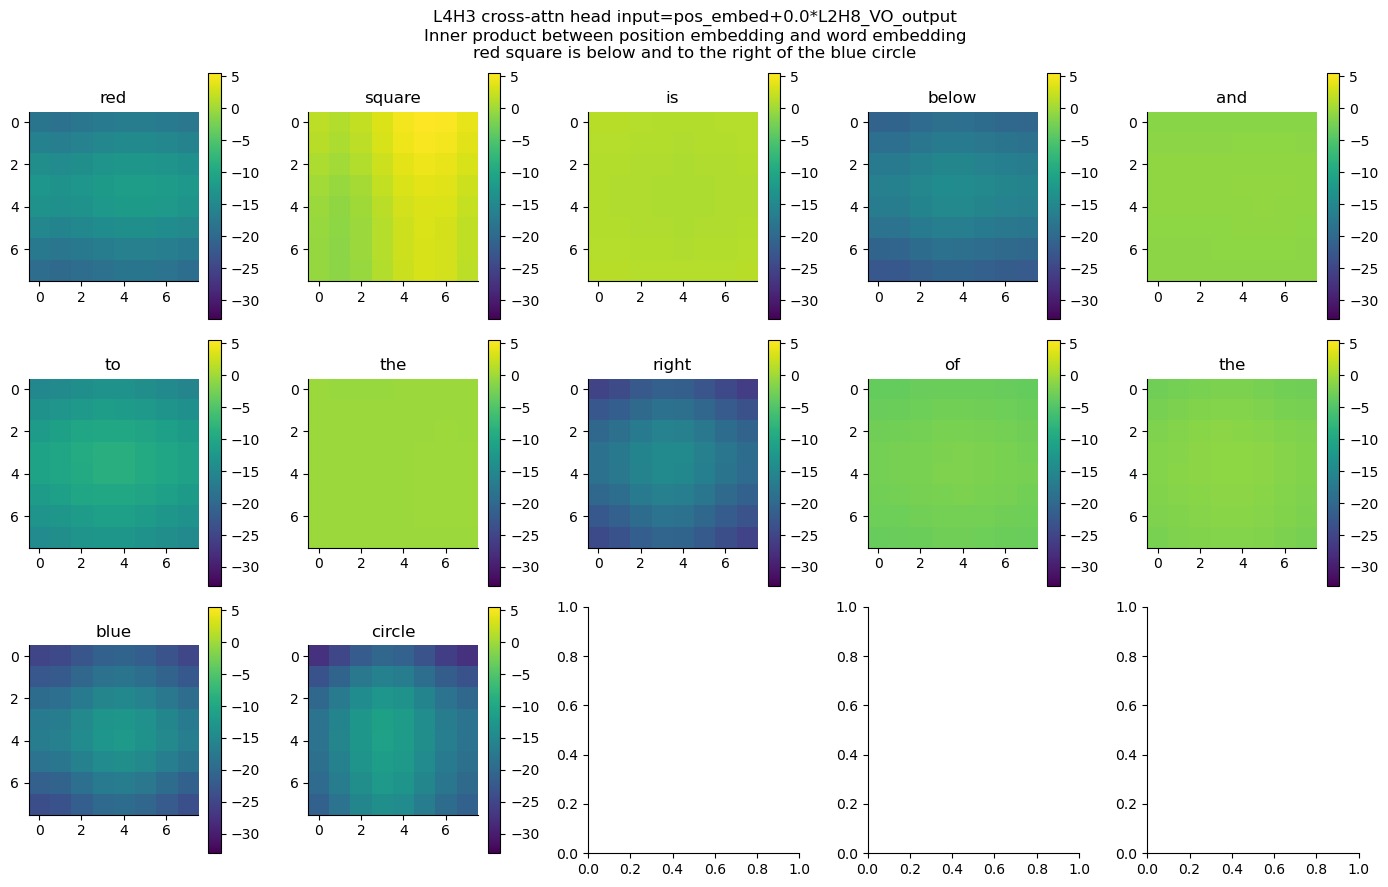

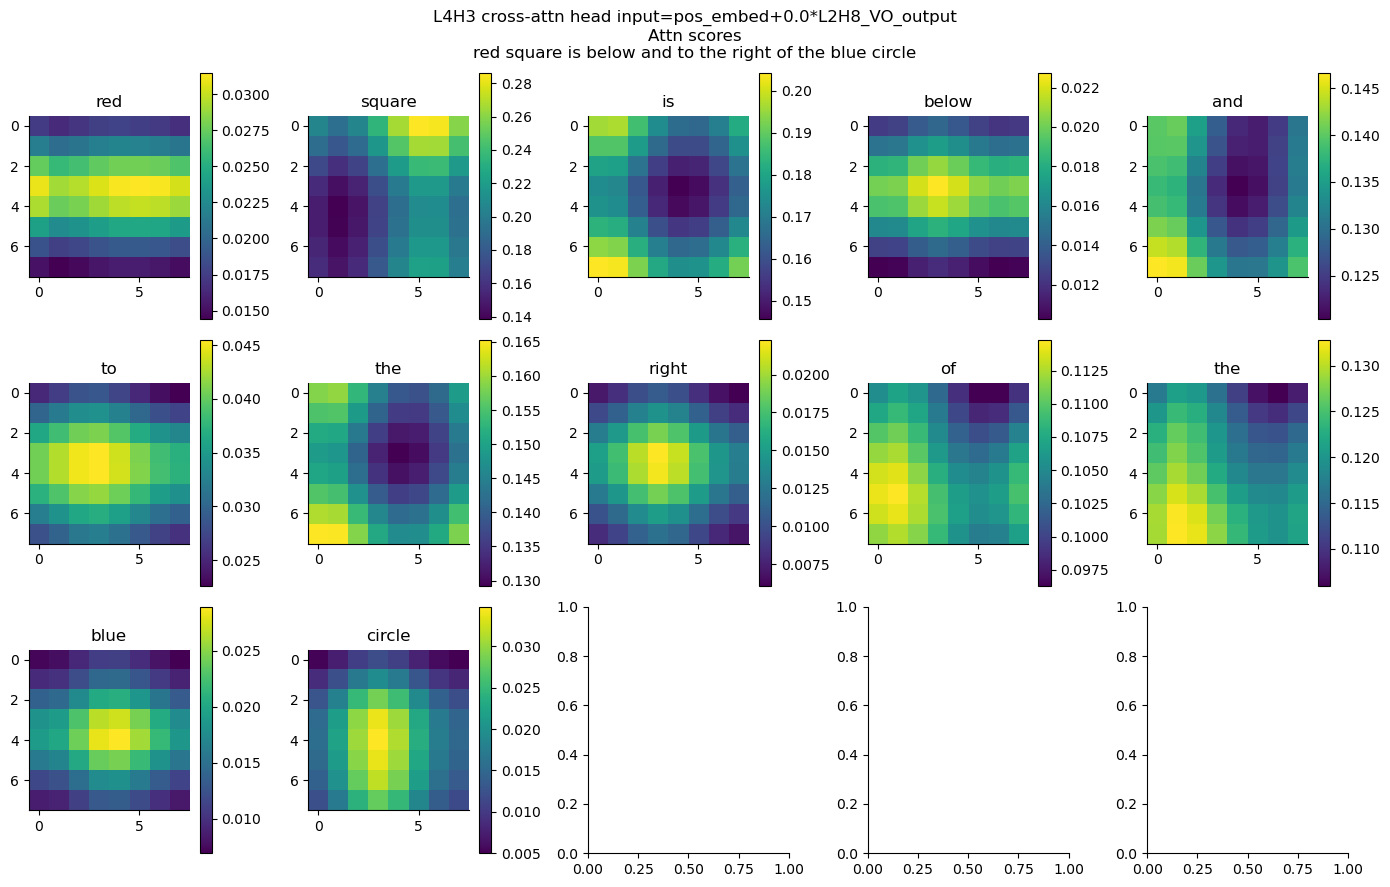

In [40]:
hidden_size = 768
base_size = 16 // 2
head_dim = hidden_size // 12
head_idx = 8
layer_idx = 2
device = "cpu"
prompt_tokenized = prompt.split(" ")
token_ids = pipeline.tokenizer.encode(" ".join(prompt_tokenized), max_length=20, truncation=False)
word_embeds, attn_mask = pipeline.text_encoder(token_ids)
with torch.no_grad():
    word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
    word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(word_embeds_proj)
    word_embed_2k_h8 = word_embed_2k[:, head_idx*head_dim:(head_idx+1)*head_dim]
    word_embed_2v = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_v(word_embeds_proj)
    word_embed_2v_h8 = word_embed_2v[:, head_idx*head_dim:(head_idx+1)*head_dim]
    word_embed_2v_h8_zero_pad = torch.zeros_like(word_embed_2v)
    word_embed_2v_h8_zero_pad[:, head_idx*head_dim:(head_idx+1)*head_dim] = word_embed_2v_h8
    word_embed_2v_h8_zero_pad_out = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_out[0](word_embed_2v_h8_zero_pad)
    # L2H8 cross-attn head
    pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
    pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
    pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
    pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
    inner_prods = (pos_embed_2q_h8 @ word_embed_2k_h8.T) / math.sqrt(head_dim)
    attn_scores = th.softmax(inner_prods.float(), dim=-1)
    attn_weighted_word_embed_2v_h8_zero_pad = attn_scores.half() @ word_embed_2v_h8_zero_pad
    final_L2H8_head_out = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_out[0](attn_weighted_word_embed_2v_h8_zero_pad)
word_embed_2v_h8_zero_pad_out.shape
final_L2H8_head_out


hidden_size = 768
base_size = 16 // 2
head_dim = hidden_size // 12
head_idx = 3
layer_idx = 4
device = "cpu"
alpha = 0.0
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
prompt_tokenized = prompt.split(" ")
token_ids = pipeline.tokenizer.encode(" ".join(prompt_tokenized), max_length=20, truncation=False)
word_embeds, attn_mask = pipeline.text_encoder(token_ids)
word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(word_embeds_proj)
word_embed_2k_h8 = word_embed_2k[:, head_idx*head_dim:(head_idx+1)*head_dim]
# implant the output of L2H8 VO output to the position encoding
pos_embed_plus_info = final_L2H8_head_out.unsqueeze(0) * alpha + pos_embed.half().cuda()
pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed_plus_info)
pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
inner_prods = (pos_embed_2q_h8 @ word_embed_2k_h8.T).detach().cpu()
figh, axs = plt.subplots(3, 5, figsize=(14, 9))
axs = axs.flatten()
vmax = inner_prods.max()
vmin = inner_prods.min()
for i_word in range(len(prompt_tokenized)):
    plt.sca(axs[i_word])
    inner_prod = inner_prods[:, i_word:i_word+1]
    plt.imshow(inner_prod.view(8, 8).detach().cpu().numpy(), vmax=vmax, vmin=vmin)
    plt.colorbar()
    plt.title(prompt_tokenized[i_word])
plt.suptitle(f"L4H3 cross-attn head input=pos_embed+{alpha}*L2H8_VO_output\nInner product between position embedding and word embedding\n{prompt}")
saveallforms(figdir, f"L4H3_cross_attn_head_inprod_img_pos_embd_plus_alpha{alpha}_L2H8_VO_output_and_word_embed_MLP_prompt_{prompt.replace(' ', '_')}")
plt.tight_layout()
plt.show()

attn_scores_L4H3 = (inner_prods / math.sqrt(head_dim)).softmax(dim=-1)
figh, axs = plt.subplots(3, 5, figsize=(14, 9))
axs = axs.flatten()
for i_word in range(len(prompt_tokenized)):
    plt.sca(axs[i_word])
    attn_scores_per_word = attn_scores_L4H3[:, i_word:i_word+1]
    plt.imshow(attn_scores_per_word.view(8, 8).detach().cpu().numpy())
    plt.colorbar()
    plt.title(prompt_tokenized[i_word])
plt.suptitle(f"L4H3 cross-attn head input=pos_embed+{alpha}*L2H8_VO_output\nAttn scores\n{prompt}")
plt.tight_layout()
saveallforms(figdir, f"L4H3_cross_attn_head_attn_scores_img_pos_embd_plus_alpha{alpha}_L2H8_VO_output_and_word_embed_MLP_prompt_{prompt.replace(' ', '_')}")
plt.show()

### Screening of Heads

In [ ]:
from circuit_toolkit.plot_utils import saveallforms

In [ ]:
pipeline.tokenizer.decode(pipeline.text_encoder.input_ids2dict_ids.keys())

'<pad></s>the and to of is from uply than right down left below above red higher lower directly blue square upper circle triangle diagonal'

In [ ]:
len(["above", "below", "right", "left", "up", "down", "diagonal", "upper", "higher", "lower", "directly", "from",
                          "square", "circle", "triangle", "red", "blue", "and", "the", "of", "to"])

21

In [ ]:
figdir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_posenc_word_emb_filtering"
os.makedirs(figdir, exist_ok=True)

In [ ]:
hidden_size = 768
base_size = 16 // 2
head_dim = hidden_size // 12
layer_idx = 3
head_idx = 1
for layer_idx in range(12):
    for head_idx in range(12):
        print(f"L{layer_idx}H{head_idx}")
        device = "cpu"
        relation_words = ["above", "below", "right", "left", "up", "down", "diagonal", "upper", "higher", "lower", "directly", "from",
                        "square", "circle", "triangle", "red", "blue", "and", "the", ][::-1]
        token_ids = pipeline.tokenizer.encode(" ".join(relation_words), max_length=25, truncation=False)
        word_embeds, attn_mask = pipeline.text_encoder(token_ids)
        word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
        word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(word_embeds_proj)
        word_embed_2k_h8 = word_embed_2k[:, head_idx*head_dim:(head_idx+1)*head_dim]
        pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
        pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
        pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
        pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
        figh, axs = plt.subplots(4, 5, figsize=(14, 11))
        axs = axs.flatten()
        inner_prods = (pos_embed_2q_h8 @ word_embed_2k_h8.T).detach().cpu()
        vmax = inner_prods.max().item()
        vmin = inner_prods.min().item()
        for i_word in range(len(relation_words)):
            plt.sca(axs[i_word])
            inner_prod = inner_prods[:, i_word:i_word+1]
            plt.imshow(inner_prod.view(8, 8).detach().cpu().numpy(), vmax=vmax, vmin=vmin)
            plt.colorbar()
            plt.title(relation_words[i_word])
        plt.suptitle(f"L{layer_idx}H{head_idx} cross-attn head\nInner product between position embedding and word embedding")
        plt.tight_layout()
        saveallforms(figdir, f"L{layer_idx}H{head_idx}_cross_attn_head_posenc_word_inner_prod.png")
        plt.close()
        plt.show()

L0H0
L0H1
L0H2
L0H3
L0H4
L0H5
L0H6
L0H7
L0H8
L0H9
L0H10
L0H11
L1H0
L1H1
L1H2
L1H3
L1H4
L1H5
L1H6
L1H7
L1H8
L1H9
L1H10
L1H11
L2H0
L2H1
L2H2
L2H3
L2H4
L2H5
L2H6
L2H7
L2H8
L2H9
L2H10
L2H11
L3H0
L3H1
L3H2
L3H3
L3H4
L3H5
L3H6
L3H7
L3H8
L3H9
L3H10
L3H11
L4H0
L4H1
L4H2
L4H3
L4H4
L4H5
L4H6
L4H7
L4H8
L4H9
L4H10
L4H11
L5H0
L5H1
L5H2
L5H3
L5H4
L5H5
L5H6
L5H7
L5H8
L5H9
L5H10
L5H11
L6H0
L6H1
L6H2
L6H3
L6H4
L6H5
L6H6
L6H7
L6H8
L6H9
L6H10
L6H11
L7H0
L7H1
L7H2
L7H3
L7H4
L7H5
L7H6
L7H7
L7H8
L7H9
L7H10
L7H11
L8H0
L8H1
L8H2
L8H3
L8H4
L8H5
L8H6
L8H7
L8H8
L8H9
L8H10
L8H11
L9H0
L9H1
L9H2
L9H3
L9H4
L9H5
L9H6
L9H7
L9H8
L9H9
L9H10
L9H11
L10H0
L10H1
L10H2
L10H3
L10H4
L10H5
L10H6
L10H7
L10H8
L10H9
L10H10
L10H11
L11H0
L11H1
L11H2
L11H3
L11H4
L11H5
L11H6
L11H7
L11H8
L11H9
L11H10
L11H11


### Structure of relation words embeddings w.r.t. keys

In [ ]:
layer_idx = 2
head_idx = 8
head_dim = 768 // 12
relation_words = ["above", "up", "upper", "higher", "below", "down", "lower", "right", "left", "diagonal", "directly", 
                        "square", "circle", "triangle", "red", "blue", "and", "the", "of", ][::-1]
token_ids = pipeline.tokenizer.encode(" ".join(relation_words), max_length=25, truncation=False)
with torch.no_grad():
    word_embeds, attn_mask = pipeline.text_encoder(token_ids)
    word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
    word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(word_embeds_proj)
    word_embed_2k_h8 = word_embed_2k[:, head_idx*head_dim:(head_idx+1)*head_dim]

In [174]:
word_embed_2k.shape

torch.Size([20, 768])

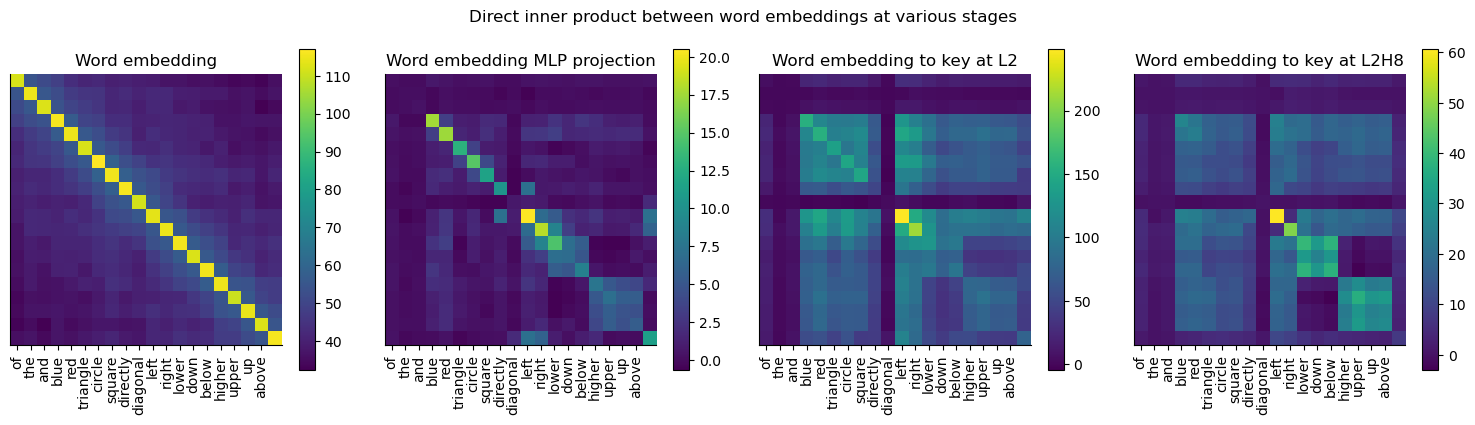

In [179]:
plt.figure(figsize=(15, 4))
plt.subplot(1,4,1)
plt.imshow((word_embeds @ word_embeds.T).detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding")
plt.subplot(1,4,2)
plt.imshow((word_embeds_proj @ word_embeds_proj.T).detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding MLP projection")
plt.subplot(1,4,3)
plt.imshow((word_embed_2k @ word_embed_2k.T).detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding to key at L2")
plt.subplot(1,4,4)
plt.imshow((word_embed_2k_h8 @ word_embed_2k_h8.T).detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding to key at L2H8")
plt.suptitle("Direct inner product between word embeddings at various stages")
plt.tight_layout()
plt.show()

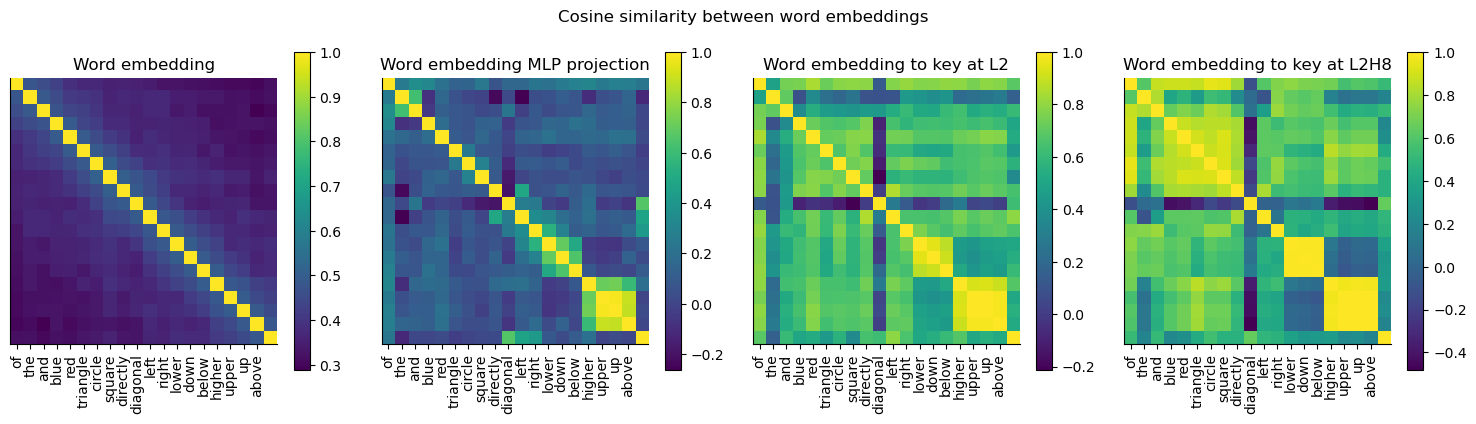

In [180]:
word_embeds = word_embeds.float()
word_embeds_proj = word_embeds_proj.float()
word_embed_2k = word_embed_2k.float()
word_embed_2k_h8 = word_embed_2k_h8.float()

# Compute cosine similarities
word_embeds_norm = word_embeds / word_embeds.norm(dim=-1, keepdim=True)
word_embeds_proj_norm = word_embeds_proj / word_embeds_proj.norm(dim=-1, keepdim=True)
word_embed_2k_norm = word_embed_2k / word_embed_2k.norm(dim=-1, keepdim=True)
word_embed_2k_h8_norm = word_embed_2k_h8 / word_embed_2k_h8.norm(dim=-1, keepdim=True)

plt.figure(figsize=(15, 4))
plt.subplot(1,4,1)
plt.imshow((word_embeds_norm @ word_embeds_norm.T).detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding")
plt.subplot(1,4,2)
plt.imshow((word_embeds_proj_norm @ word_embeds_proj_norm.T).detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding MLP projection")
plt.subplot(1,4,3)
plt.imshow((word_embed_2k_norm @ word_embed_2k_norm.T).detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding to key at L2")
plt.subplot(1,4,4)
plt.imshow((word_embed_2k_h8_norm @ word_embed_2k_h8_norm.T).detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding to key at L2H8")
plt.suptitle("Cosine similarity between word embeddings")
plt.tight_layout()
plt.show()

In [181]:

# Compute L2 distances
# word_embeds_expanded = word_embeds.unsqueeze(1)
# word_embeds_proj_expanded = word_embeds_proj.unsqueeze(1)
# word_embed_2k_expanded = word_embed_2k.unsqueeze(1)
# word_embed_2k_h8_expanded = word_embed_2k_h8.unsqueeze(1)
l2_dist_embeds = torch.cdist(word_embeds, word_embeds, p=2)
l2_dist_proj = torch.cdist(word_embeds_proj, word_embeds_proj, p=2)
l2_dist_2k = torch.cdist(word_embed_2k, word_embed_2k, p=2)
l2_dist_2k_h8 = torch.cdist(word_embed_2k_h8, word_embed_2k_h8, p=2)

plt.figure(figsize=(15, 4))
plt.subplot(1,4,1)
plt.imshow(l2_dist_embeds.detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding")
plt.subplot(1,4,2)
plt.imshow(l2_dist_proj.detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding MLP projection")
plt.subplot(1,4,3)
plt.imshow(l2_dist_2k.detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding to key at L2")
plt.subplot(1,4,4)
plt.imshow(l2_dist_2k_h8.detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding to key at L2H8")
plt.suptitle("L2 distance between word embeddings")
plt.tight_layout()
plt.show()

### Structure of Position embeding w.r.t. query

In [190]:
head_idx = 8
layer_idx = 2
head_dim = 768 // 12
with torch.no_grad():
    pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
    pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
    pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
    pos_embed_2q_h8 = pos_embed_2q[:, :, head_idx*head_dim:(head_idx+1)*head_dim]

In [ ]:
pos_embed_2q_h8

In [202]:
W_q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q.weight
b_q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q.bias
W_q_h8 = W_q[head_idx*head_dim:(head_idx+1)*head_dim, :]
b_q_h8 = b_q[head_idx*head_dim:(head_idx+1)*head_dim]

In [ ]:
U, S, V = th.svd(W_q_h8.float())


In [242]:
V.shape

torch.Size([768, 64])

In [247]:
(pos_embed[0] - (pos_embed[0] @ V @ th.diag(S**2) @ V.T)).norm()

tensor(370.3118)

In [210]:
assert (torch.allclose(pos_embed_2q_h8.float(), pos_embed.cuda().float() @ W_q_h8.T.cuda().float() + b_q_h8.cuda().float(), rtol=1e-3, atol=1e-3))

In [271]:
head_idx = 9
layer_idx = 5
head_dim = 768 // 12
with torch.no_grad():
    pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
    pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).cuda()
    # pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
    # pos_embed_2q_h8 = pos_embed_2q[:, :, head_idx*head_dim:(head_idx+1)*head_dim]
    W_q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q.weight
    # b_q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q.bias
    W_q_h8 = W_q[head_idx*head_dim:(head_idx+1)*head_dim, :]
    # b_q_h8 = b_q[head_idx*head_dim:(head_idx+1)*head_dim]
    U, S, V = th.svd(W_q_h8.float())
    proj_var = (pos_embed[0] @ V @ th.diag(S**2) @ V.T).norm().item()
    proj_space_var = (pos_embed[0] @ V @ V.T).norm().item()
    residual_VS2V = (pos_embed[0] - (pos_embed[0] @ V @ th.diag(S**2) @ V.T)).norm().item()
    residual_V = (pos_embed[0] - (pos_embed[0] @ V @ V.T)).norm().item()
    pos_embed_var = pos_embed[0].norm().item()
    # print(f"Explained variance: {1 - residual_VS2V / pos_embed_var}, subspace: {1 - residual_V / pos_embed_var}")
    print(f"Proj var: {proj_var}, proj space var: {proj_space_var}")

Proj var: 392.2591552734375, proj space var: 61.26609802246094


In [212]:
W_q_h8.shape

torch.Size([64, 768])

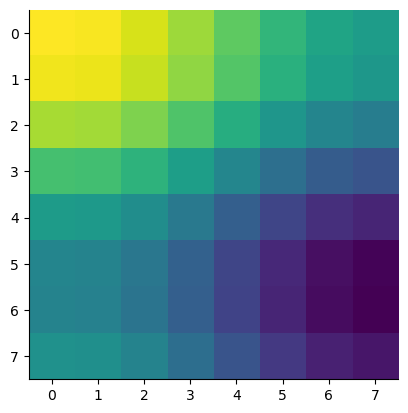

In [220]:
plt.imshow(pos_embed_2q_h8[0,:,-10].view(8, 8).detach().cpu())

In [221]:
W_q_h8.shape

torch.Size([64, 768])

In [224]:
W_q_h8 = W_q_h8.detach().float().cpu()

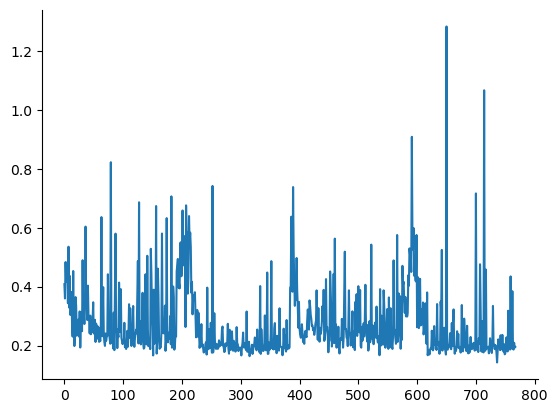

In [225]:
plt.plot(W_q_h8.float().cpu().norm(dim=0))

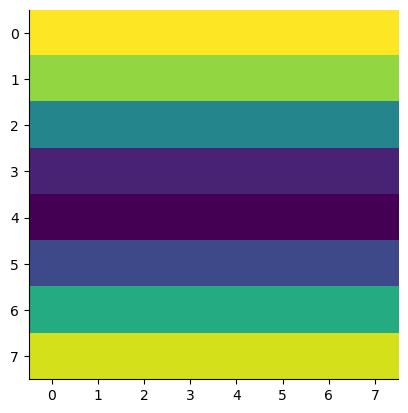

In [236]:
plt.imshow(pos_embed[0, :, 580].view(base_size, base_size).detach().cpu().numpy())

### Scratch

In [ ]:
pipeline.transformer

Transformer2DModel(
  (pos_embed): PatchEmbed(
    (proj): Conv2d(4, 768, kernel_size=(2, 2), stride=(2, 2))
  )
  (transformer_blocks): ModuleList(
    (0-11): 12 x BasicTransformerBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
      (attn1): Attention(
        (to_q): Linear(in_features=768, out_features=768, bias=True)
        (to_k): Linear(in_features=768, out_features=768, bias=True)
        (to_v): Linear(in_features=768, out_features=768, bias=True)
        (to_out): ModuleList(
          (0): Linear(in_features=768, out_features=768, bias=True)
          (1): Dropout(p=0.0, inplace=False)
        )
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
      (attn2): Attention(
        (to_q): Linear(in_features=768, out_features=768, bias=True)
        (to_k): Linear(in_features=768, out_features=768, bias=True)
        (to_v): Linear(in_features=768, out_features=768, bias=True)
        (to_out): ModuleList(
          (0):

In [ ]:
pipeline.transformer.transformer_blocks[2].attn2.to_k

Linear(in_features=768, out_features=768, bias=True)

In [ ]:
pipeline.transformer.transformer_blocks[2].attn2.to_q

Linear(in_features=768, out_features=768, bias=True)

In [ ]:
hidden_size = 768
base_size = 16 // 2
device = "cpu"
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)

In [ ]:
pos_embed_2q = pipeline.transformer.transformer_blocks[2].attn2.to_q(pos_embed.half().cuda())

In [ ]:
pos_embed.shape

torch.Size([1, 64, 768])

In [ ]:
head_dim = hidden_size // 12
head_idx = 8
pos_embed_2q_h8 = pos_embed_2q[:, :, head_idx*head_dim:(head_idx+1)*head_dim]

In [ ]:
from inspect import signature, getsource
print(getsource(pipeline.tokenizer.encode))

    @add_end_docstrings(
        ENCODE_KWARGS_DOCSTRING,
        """
            **kwargs: Passed along to the `.tokenize()` method.
        """,
        """
        Returns:
            `List[int]`, `torch.Tensor`, `tf.Tensor` or `np.ndarray`: The tokenized ids of the text.
        """,
    )
    def encode(
        self,
        text: Union[TextInput, PreTokenizedInput, EncodedInput],
        text_pair: Optional[Union[TextInput, PreTokenizedInput, EncodedInput]] = None,
        add_special_tokens: bool = True,
        padding: Union[bool, str, PaddingStrategy] = False,
        truncation: Union[bool, str, TruncationStrategy] = None,
        max_length: Optional[int] = None,
        stride: int = 0,
        return_tensors: Optional[Union[str, TensorType]] = None,
        **kwargs,
    ) -> List[int]:
        """
        Converts a string to a sequence of ids (integer), using the tokenizer and vocabulary.

        Same as doing `self.convert_tokens_to_ids(self.tokenize(text))`.

     

In [ ]:
relation_words = ["above", "below", "right", "left"]
token_ids = pipeline.tokenizer.encode(" ".join(relation_words), max_length=20, truncation=False)
word_embeds, attn_mask = pipeline.text_encoder(token_ids)
word_embeds.shape

torch.Size([5, 4096])

In [ ]:
pipeline.transformer.caption_projection

PixArtAlphaTextProjection(
  (linear_1): Linear(in_features=4096, out_features=768, bias=True)
  (act_1): GELU(approximate='tanh')
  (linear_2): Linear(in_features=768, out_features=768, bias=True)
)

In [ ]:
word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)

In [ ]:
word_embed_2k = pipeline.transformer.transformer_blocks[2].attn2.to_k(word_embeds_proj)

In [ ]:
word_embed_2k.shape

torch.Size([5, 768])

In [ ]:
word_embed_2k_h8 = word_embed_2k[:, head_idx*head_dim:(head_idx+1)*head_dim]

In [ ]:
word_embed_2k_h8.shape

torch.Size([5, 64])

In [ ]:
pos_embed_2q_h8.shape

torch.Size([1, 64, 64])

In [ ]:
figh, axs = plt.subplots(2, 2, figsize=(6, 6))
axs = axs.flatten()
for i_word in range(len(relation_words)):
    plt.sca(axs[i_word])
    inner_prod = pos_embed_2q_h8[0] @ word_embed_2k_h8[i_word:i_word+1].T
    plt.imshow(inner_prod.view(8, 8).detach().cpu().numpy())
    plt.colorbar()
    plt.title(relation_words[i_word])
plt.suptitle(f"L2H8 cross-attn head\nInner product between position embedding and word embedding")
plt.tight_layout()
plt.show()